In [293]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import os
import windrose as wr
import scipy as sc
import scipy.stats as stats
from scipy.optimize import curve_fit
import statsmodels.api as sm

In [14]:
def moving_sum(data,n):
    ret = np.nancumsum(data, dtype=np.float64)  # считаем кумулятивную сумму
    ret[n:] = ret[n:]-ret[:-n] # вычитаем все, что накопилось до начала окна суммирования 
    return ret[n-1:] # Пример работы: [[1,2,3],7,10] -> [6,]; [1,[2,3,7],10] -> [6,12,]; [1,2,[3,7,10]] -> [6,12,20] 

def moving_average(data, n):
    return moving_sum(data,n)/n

def drop_spikes(data, nsig=3.5, n=3):
    mean = np.nanmean(data)
    std = np.nanstd(data)
    max_ = mean + nsig*std  # верхняя граница
    min_ = mean - nsig*std  # нижняя граница
    mask = (data>max_)|(data<min_)  # определяем маску превышений
    msum = moving_sum(mask,n)  # считем для каждого элемента маски сумму в заданном окне 
    for i in np.where(msum >= n)[0]:  # сумма больше n означает, что в этом месте n или более подряд идущих превышений  
        mask[i:i+n] = False  # исключаем из маски серии превышений длинее n  
    data[mask] = np.nan # удаляем превышения
    return data

def nan_counter(data):
    return np.count_nonzero(np.isnan(data)) 

def ax_c(x,a,c):
    return a*x+c

def trend(data, func):
    n = len(data)
    not_nan = np.logical_not(np.isnan(data))
    x = np.arange(n)
    coef, _ = curve_fit(func, x[not_nan], data[not_nan])
    return func(x,*coef)
    
def stat_moments(input_dir, file_name, l, m, ma=False, ma_n=0, p_ma=False):
    
    files = os.listdir(input_dir)  # список файлов в папке с данными
    files.sort()
    
    N1 = 72000         # измерений в одном файле      
    N = N1*len(files)  # измерений на одном уровне
    m = m*60*20        # период осреднения (в количестве измерений)
    D = N//m           # двадцатиминуток на одном уровне
    D1 = N1//m         # двадцатиминуток в одном файле

    # в зависимости от прибора используем разные индексы для считывания данных из строк файла
    # lvl[0] - индекс u, lvl[1] - индекс v, lvl[2] - индекс w, lvl[3] - индекс T 
    if l == 'frank': lvl = [5,3,7,9] 
    elif l == 'ifa': lvl = [4,7,10,13]
    else: lvl = [3,5,7,9]

    U, V, W, T = np.zeros(m, dtype=np.float64), np.zeros(m, dtype=np.float64), np.zeros(m, dtype=np.float64), np.zeros(m, dtype=np.float64)

    #создаем новый файл для записи, добавляем шапку таблицы 
    new_f = open(file_name,'w')
    header = '%20s,'*19+'%20s\n'
    new_f.write(header%('avg_U','avg_V','avg_W','Tac','std_Uh',
                        'UU','VV','WW','TT','WU','WV','WT',
                        'WWT','WTT','WUU','WVV','WWW','TTT','UUU','VVV'))

    file_counter = 0  # счетчик файлов

    for file in files:  # цикл по файлам в папке
        inf = open(os.path.join(input_dir, file))

        if file_counter % 240 == 0:  # выводим раз в 10 сутoк имя обрабатываемого файла, чтобы отслеживать прогресс
            print(l, file, f'complited in month: {np.round(file_counter/len(files)*100)}%')

        file_counter += 1

        for i in range(D1):  # цикл по двадцатиминуткам в файле
            for j in range(m):  # цикл по количеству измерений за 20 минут
                try:
                    line = inf.readline()  # считываем строку из файла
                    data = line.split()  # разбиваем ее на элементы

                    if data[2] == 'E:invalid':  # если прочитанная строка является сообщением об ошибке, пропускаем ее
                        continue

                    # считываем данные из разбитой строки
                    if l == 'ifa':
                        U[j] = np.float64(data[lvl[0]])/100 
                        V[j] = np.float64(data[lvl[1]])/100
                        W[j] = np.float64(data[lvl[2]])/100
                        T[j] = np.float64(data[lvl[3]])/100
                    else:
                        U[j] = np.float64(data[lvl[0]])
                        V[j] = np.float64(data[lvl[1]])
                        W[j] = np.float64(data[lvl[2]])
                        T[j] = np.float64(data[lvl[3]])

                # если строка считывается некорректно, записываем Nan
                except(ValueError, IndexError):
                    U[j], V[j], W[j], T[j] = np.nan, np.nan, np.nan, np.nan 
                    continue

            # удаление пиков 
            U = drop_spikes(U, nsig=3.5, n=3)
            V = drop_spikes(V, nsig=3.5, n=3)
            W = drop_spikes(W, nsig=5, n=3)
            T = drop_spikes(T, nsig=3.5, n=3)

            # количество пропусков
            Nan = max(nan_counter(U),nan_counter(V),nan_counter(W),nan_counter(T))

            if Nan/m > 0.2: #если за 20 минут некорректных значений больше 10%, двадцатиминутка не учитывается, все характеристики заполняем Nan
                print(l, file, i, Nan, Nan/m*100)
                avg_U, avg_V, avg_W, Tac, std_Uh = np.nan, np.nan, np.nan, np.nan, np.nan
                UU, VV, WW, TT, WU, WV, WT = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan 
                WWT, WTT, WUU, WVV, WWW, TTT, UUU, VVV = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

                out = '%20.15f,'*19+'%20.15f\n'
                new_f.write(out%(avg_U, avg_V, avg_W, Tac, std_Uh,
                                 UU, VV, WW, TT, WU, WV, WT,
                                 WWT, WTT, WUU, WVV, WWW, TTT, UUU, VVV))

                continue

            # заполнение пропусков

            # центральные моменты
            avg_U, avg_V, avg_W, Tac = np.nanmean(U, dtype=np.float64), np.nanmean(V, dtype=np.float64), np.nanmean(W, dtype=np.float64), np.nanmean(T, dtype=np.float64)
            if l == 'ifa': Tac += 0.286

            # расчет линейного тренда
            lin_U = trend(U, ax_c)
            lin_V = trend(V, ax_c)
            lin_W = trend(W, ax_c)
            lin_T = trend(T, ax_c)

            # пульсации с детрендингом
            pU, pV, pW, pT = U-lin_U, V-lin_V, W-lin_W, T-lin_T

            # вторые моменты
            std_Uh = np.nanstd(np.sqrt(U**2+V**2))

            UU = np.nanmean(pU*pU, dtype=np.float64)
            VV = np.nanmean(pV*pV, dtype=np.float64)
            WW = np.nanmean(pW*pW, dtype=np.float64)
            TT = np.nanmean(pT*pT, dtype=np.float64)
            WU = np.nanmean(pW*pU, dtype=np.float64)
            WV = np.nanmean(pW*pV, dtype=np.float64)
            WT = np.nanmean(pW*pT, dtype=np.float64)

            # третьи моменты
            WWT = np.nanmean(pW*pW*pT, dtype=np.float64)
            WTT = np.nanmean(pW*pT*pT, dtype=np.float64)
            WUU = np.nanmean(pW*pU*pU, dtype=np.float64)
            WVV = np.nanmean(pW*pV*pV, dtype=np.float64)
            WWW = np.nanmean(pW*pW*pW, dtype=np.float64)
            TTT = np.nanmean(pT*pT*pT, dtype=np.float64)
            UUU = np.nanmean(pU*pU*pU, dtype=np.float64)
            VVV = np.nanmean(pV*pV*pV, dtype=np.float64)

            out = '%20.15f,'*19+'%20.15f\n'
            new_f.write(out%(avg_U, avg_V, avg_W, Tac, std_Uh, 
                             UU, VV, WW, TT, WU, WV, WT, 
                             WWT, WTT, WUU, WVV, WWW, TTT, UUU, VVV))

        inf.close()
    new_f.close()
        

In [ ]:
# запустил расчет в 22:10

In [15]:
input_directory='/Users/ilyadrozd/Desktop/TOWER_DATA/input/'  # отсюда берем 
output_directory='/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/'  # сюда кладем
level=['frank', 'ifa', 'io']  # уровни приборов
months=['November', 'December', 'January', 'February', 'March', 'April', 'May']  # доступные месяцы

# input_dir - директория с входными даннымми
# file_name - выходной файл с даннымми
# l - название прибора 
# m - период осреднения (в минутах)
for month in months:
    for l in level:
        stat_moments(f'/Users/ilyadrozd/Desktop/TOWER_DATA/input/{l}/{month}', f'/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/{l}/{month}/lin_20min.csv', l = l, m = 20)
        

frank 191101000000.dat complited in month: 0.0%
frank 191103130000.dat 2 7098 29.575000000000003
frank 191103140000.dat 0 24000 100.0
frank 191103140000.dat 1 24000 100.0


/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_93443/1743673609.py:10: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data)


frank 191103140000.dat 2 24000 100.0
frank 191103150000.dat 0 24000 100.0
frank 191103150000.dat 1 24000 100.0
frank 191103150000.dat 2 24000 100.0
frank 191103160000.dat 0 24000 100.0
frank 191103160000.dat 1 24000 100.0
frank 191103160000.dat 2 24000 100.0
frank 191103170000.dat 0 24000 100.0
frank 191103170000.dat 1 24000 100.0
frank 191103170000.dat 2 24000 100.0
frank 191103180000.dat 0 24000 100.0
frank 191103180000.dat 1 24000 100.0
frank 191103180000.dat 2 24000 100.0
frank 191103190000.dat 0 24000 100.0
frank 191103190000.dat 1 24000 100.0
frank 191103190000.dat 2 24000 100.0
frank 191103200000.dat 0 24000 100.0
frank 191103200000.dat 1 24000 100.0
frank 191103200000.dat 2 24000 100.0
frank 191103210000.dat 0 24000 100.0
frank 191103210000.dat 1 24000 100.0
frank 191103210000.dat 2 24000 100.0
frank 191103220000.dat 0 24000 100.0
frank 191103220000.dat 1 24000 100.0
frank 191103220000.dat 2 24000 100.0
frank 191103230000.dat 0 24000 100.0
frank 191103230000.dat 1 24000 100.0
f

frank 191106170000.dat 0 24000 100.0
frank 191106170000.dat 1 24000 100.0
frank 191106170000.dat 2 24000 100.0
frank 191106180000.dat 0 24000 100.0
frank 191106180000.dat 1 24000 100.0
frank 191106180000.dat 2 24000 100.0
frank 191106190000.dat 0 24000 100.0
frank 191106190000.dat 1 24000 100.0
frank 191106190000.dat 2 24000 100.0
frank 191106200000.dat 0 24000 100.0
frank 191106200000.dat 1 24000 100.0
frank 191106200000.dat 2 24000 100.0
frank 191106210000.dat 0 24000 100.0
frank 191106210000.dat 1 24000 100.0
frank 191106210000.dat 2 24000 100.0
frank 191106220000.dat 0 24000 100.0
frank 191106220000.dat 1 24000 100.0
frank 191106220000.dat 2 24000 100.0
frank 191106230000.dat 0 24000 100.0
frank 191106230000.dat 1 24000 100.0
frank 191106230000.dat 2 24000 100.0
frank 191107000000.dat 0 24000 100.0
frank 191107000000.dat 1 24000 100.0
frank 191107000000.dat 2 24000 100.0
frank 191107010000.dat 0 24000 100.0
frank 191107010000.dat 1 24000 100.0
frank 191107010000.dat 2 24000 100.0
f

frank 191129220000.dat 0 12287 51.195833333333326
frank 191130010000.dat 0 6555 27.3125
frank 191130010000.dat 2 18438 76.825
frank 191130020000.dat 0 5372 22.383333333333333
frank 191130030000.dat 2 12193 50.80416666666666
ifa 191101000000.dat complited in month: 0.0%
ifa 191103130000.dat 2 4889 20.370833333333334
ifa 191103140000.dat 0 24000 100.0
ifa 191103140000.dat 1 24000 100.0
ifa 191103140000.dat 2 24000 100.0
ifa 191103150000.dat 0 24000 100.0
ifa 191103150000.dat 1 24000 100.0
ifa 191103150000.dat 2 24000 100.0
ifa 191103160000.dat 0 24000 100.0
ifa 191103160000.dat 1 24000 100.0
ifa 191103160000.dat 2 24000 100.0
ifa 191103170000.dat 0 24000 100.0
ifa 191103170000.dat 1 24000 100.0
ifa 191103170000.dat 2 24000 100.0
ifa 191103180000.dat 0 24000 100.0
ifa 191103180000.dat 1 24000 100.0
ifa 191103180000.dat 2 24000 100.0
ifa 191103190000.dat 0 24000 100.0
ifa 191103190000.dat 1 24000 100.0
ifa 191103190000.dat 2 24000 100.0
ifa 191103200000.dat 0 24000 100.0
ifa 191103200000.d

ifa 191106170000.dat 2 24000 100.0
ifa 191106180000.dat 0 24000 100.0
ifa 191106180000.dat 1 24000 100.0
ifa 191106180000.dat 2 24000 100.0
ifa 191106190000.dat 0 24000 100.0
ifa 191106190000.dat 1 24000 100.0
ifa 191106190000.dat 2 24000 100.0
ifa 191106200000.dat 0 24000 100.0
ifa 191106200000.dat 1 24000 100.0
ifa 191106200000.dat 2 24000 100.0
ifa 191106210000.dat 0 24000 100.0
ifa 191106210000.dat 1 24000 100.0
ifa 191106210000.dat 2 24000 100.0
ifa 191106220000.dat 0 24000 100.0
ifa 191106220000.dat 1 24000 100.0
ifa 191106220000.dat 2 24000 100.0
ifa 191106230000.dat 0 24000 100.0
ifa 191106230000.dat 1 24000 100.0
ifa 191106230000.dat 2 24000 100.0
ifa 191107000000.dat 0 24000 100.0
ifa 191107000000.dat 1 24000 100.0
ifa 191107000000.dat 2 24000 100.0
ifa 191107010000.dat 0 24000 100.0
ifa 191107010000.dat 1 24000 100.0
ifa 191107010000.dat 2 24000 100.0
ifa 191107020000.dat 0 24000 100.0
ifa 191107020000.dat 1 24000 100.0
ifa 191107020000.dat 2 24000 100.0
ifa 191107030000.dat

io 191103180000.dat 2 24000 100.0
io 191103190000.dat 0 24000 100.0
io 191103190000.dat 1 24000 100.0
io 191103190000.dat 2 24000 100.0
io 191103200000.dat 0 24000 100.0
io 191103200000.dat 1 24000 100.0
io 191103200000.dat 2 24000 100.0
io 191103210000.dat 0 24000 100.0
io 191103210000.dat 1 24000 100.0
io 191103210000.dat 2 24000 100.0
io 191103220000.dat 0 24000 100.0
io 191103220000.dat 1 24000 100.0
io 191103220000.dat 2 24000 100.0
io 191103230000.dat 0 24000 100.0
io 191103230000.dat 1 24000 100.0
io 191103230000.dat 2 24000 100.0
io 191104000000.dat 0 24000 100.0
io 191104000000.dat 1 24000 100.0
io 191104000000.dat 2 24000 100.0
io 191104010000.dat 0 24000 100.0
io 191104010000.dat 1 24000 100.0
io 191104010000.dat 2 24000 100.0
io 191104020000.dat 0 24000 100.0
io 191104020000.dat 1 24000 100.0
io 191104020000.dat 2 24000 100.0
io 191104030000.dat 0 24000 100.0
io 191104030000.dat 1 24000 100.0
io 191104030000.dat 2 24000 100.0
io 191104040000.dat 0 24000 100.0
io 19110404000

io 191107030000.dat 1 24000 100.0
io 191107030000.dat 2 24000 100.0
io 191107040000.dat 0 24000 100.0
io 191107040000.dat 1 24000 100.0
io 191107040000.dat 2 24000 100.0
io 191107050000.dat 0 24000 100.0
io 191107050000.dat 1 24000 100.0
io 191107050000.dat 2 24000 100.0
io 191107060000.dat 0 24000 100.0
io 191107060000.dat 1 24000 100.0
io 191107060000.dat 2 24000 100.0
io 191107070000.dat 0 24000 100.0
io 191107070000.dat 1 24000 100.0
io 191107070000.dat 2 24000 100.0
io 191107080000.dat 0 24000 100.0
io 191107080000.dat 1 24000 100.0
io 191107080000.dat 2 24000 100.0
io 191107090000.dat 0 24000 100.0
io 191107090000.dat 1 24000 100.0
io 191107090000.dat 2 24000 100.0
io 191107100000.dat 0 24000 100.0
io 191107100000.dat 1 24000 100.0
io 191107100000.dat 2 24000 100.0
io 191107110000.dat 0 24000 100.0
io 191107110000.dat 1 24000 100.0
io 191107110000.dat 2 24000 100.0
io 191107120000.dat 0 24000 100.0
io 191107120000.dat 1 24000 100.0
io 191107120000.dat 2 24000 100.0
io 19110713000

frank 191223020000.dat 1 6194 25.808333333333334
frank 191223020000.dat 2 5392 22.466666666666665
frank 191223030000.dat 0 5446 22.691666666666666
frank 191225170000.dat 2 23878 99.49166666666667
frank 191225181459.dat 2 18565 77.35416666666667
frank 191227000000.dat 2 4964 20.683333333333334
frank 191227010000.dat 0 5001 20.837500000000002
frank 191227010000.dat 1 5466 22.775000000000002
frank 191227010000.dat 2 6354 26.474999999999998
frank 191227020000.dat 0 7043 29.34583333333333
frank 191227020000.dat 1 6909 28.787499999999998
frank 191227020000.dat 2 7508 31.283333333333335
frank 191227030000.dat 0 8227 34.27916666666667
frank 191227030000.dat 1 8895 37.0625
frank 191227030000.dat 2 10007 41.69583333333333
frank 191227040000.dat 0 13007 54.19583333333333
frank 191227040000.dat 1 18529 77.20416666666667
frank 191227040000.dat 2 23474 97.80833333333334
frank 191227050000.dat 0 22668 94.45
frank 191227050000.dat 1 23927 99.69583333333333
frank 191227050000.dat 2 24000 100.0
frank 19

frank 191229170000.dat 1 19352 80.63333333333334
frank 191229170000.dat 2 18385 76.60416666666666
frank 191229180000.dat 0 19160 79.83333333333333
frank 191229180000.dat 1 20033 83.47083333333333
frank 191229180000.dat 2 19662 81.925
frank 191229190000.dat 0 19721 82.17083333333333
frank 191229190000.dat 1 19488 81.2
frank 191229190000.dat 2 19186 79.94166666666666
frank 191229200000.dat 0 19165 79.85416666666667
frank 191229200000.dat 1 18812 78.38333333333334
frank 191229200000.dat 2 17434 72.64166666666667
frank 191229210000.dat 0 16778 69.90833333333333
frank 191229210000.dat 1 15918 66.325
frank 191229210000.dat 2 15705 65.4375
frank 191229220000.dat 0 14892 62.050000000000004
frank 191229220000.dat 1 15652 65.21666666666667
frank 191229220000.dat 2 14938 62.24166666666666
frank 191229230000.dat 0 13973 58.22083333333333
frank 191229230000.dat 1 14230 59.291666666666664
frank 191229230000.dat 2 13623 56.7625
frank 191230000000.dat 0 13850 57.70833333333333
frank 191230000000.dat 1

ifa 191228150000.dat 0 20244 84.35000000000001
ifa 191228150000.dat 1 18437 76.82083333333334
ifa 191228150000.dat 2 17571 73.2125
ifa 191228160000.dat 0 17906 74.60833333333333
ifa 191228160000.dat 1 18269 76.12083333333334
ifa 191228160000.dat 2 18756 78.14999999999999
ifa 191228170000.dat 0 19356 80.65
ifa 191228170000.dat 1 19942 83.09166666666667
ifa 191228170000.dat 2 20418 85.075
ifa 191228180000.dat 0 19580 81.58333333333333
ifa 191228180000.dat 1 19416 80.9
ifa 191228180000.dat 2 19606 81.69166666666666
ifa 191228190000.dat 0 18567 77.3625
ifa 191228190000.dat 1 17529 73.0375
ifa 191228190000.dat 2 16760 69.83333333333334
ifa 191228200000.dat 0 15715 65.47916666666667
ifa 191228200000.dat 1 15268 63.61666666666667
ifa 191228200000.dat 2 14622 60.925
ifa 191228210000.dat 0 12881 53.670833333333334
ifa 191228210000.dat 1 11958 49.825
ifa 191228210000.dat 2 11258 46.90833333333334
ifa 191228220000.dat 0 9733 40.55416666666667
ifa 191228220000.dat 1 8836 36.81666666666666
ifa 1912

frank 200112040000.dat 2 16900 70.41666666666667
frank 200112050000.dat 0 16834 70.14166666666667
frank 200112050000.dat 1 18006 75.02499999999999
frank 200112050000.dat 2 17636 73.48333333333333
frank 200112060000.dat 0 17143 71.42916666666666
frank 200112060000.dat 1 16471 68.62916666666666
frank 200112060000.dat 2 16387 68.27916666666667
frank 200112070000.dat 0 15715 65.47916666666667
frank 200112070000.dat 1 14987 62.44583333333333
frank 200112070000.dat 2 17028 70.95
frank 200112080000.dat 0 16962 70.675
frank 200112080000.dat 1 19980 83.25
frank 200112080000.dat 2 17838 74.325
frank 200112090000.dat 0 16703 69.59583333333333
frank 200112090000.dat 1 16678 69.49166666666666
frank 200112090000.dat 2 17227 71.77916666666667
frank 200112100000.dat 0 17380 72.41666666666666
frank 200112100000.dat 1 17019 70.9125
frank 200112100000.dat 2 15723 65.51249999999999
frank 200112110000.dat 0 14725 61.354166666666664
frank 200112110000.dat 1 13814 57.55833333333334
frank 200112110000.dat 2 1

frank 200202170000.dat 2 24000 100.0
frank 200202180000.dat 0 24000 100.0
frank 200202180000.dat 1 24000 100.0
frank 200202180000.dat 2 23819 99.24583333333334
frank 200202190000.dat 0 7492 31.216666666666665
frank 200203130000.dat 0 5775 24.0625
frank 200203130000.dat 1 6508 27.116666666666667
frank 200203210000.dat 1 6769 28.20416666666667
frank 200204180000.dat 0 4876 20.316666666666666
frank 200204190000.dat 1 5075 21.145833333333332
frank 200204190000.dat 2 5131 21.379166666666666
frank 200204200000.dat 0 4849 20.204166666666666
frank 200204210000.dat 0 4932 20.549999999999997
frank 200205000000.dat 2 4878 20.325
frank 200205040000.dat 2 4867 20.27916666666667
frank 200205050000.dat 0 4806 20.025000000000002
frank 200205050000.dat 1 4905 20.4375
frank 200205050000.dat 2 4966 20.691666666666666
frank 200206000000.dat 2 4897 20.40416666666667
frank 200206010000.dat 0 5011 20.879166666666666
frank 200206010000.dat 2 5226 21.775
frank 200206020000.dat 0 5158 21.491666666666667
frank 2

frank 200213060000.dat 1 7362 30.675
frank 200213060000.dat 2 7138 29.741666666666667
frank 200213070000.dat 0 7111 29.629166666666666
frank 200213070000.dat 1 7046 29.35833333333333
frank 200213070000.dat 2 6842 28.508333333333336
frank 200213080000.dat 0 6832 28.46666666666667
frank 200213080000.dat 1 6132 25.55
frank 200213080000.dat 2 5807 24.195833333333333
frank 200213090000.dat 0 5644 23.516666666666666
frank 200213090000.dat 1 5004 20.849999999999998
frank 200221000000.dat complited in month: 69.0%
frank 200223050000.dat 1 7902 32.925
frank 200223050000.dat 2 16686 69.525
frank 200223060000.dat 0 24000 100.0
frank 200223060000.dat 1 24000 100.0
frank 200223060000.dat 2 24000 100.0
frank 200223070000.dat 0 24000 100.0
frank 200223070000.dat 1 24000 100.0
frank 200223070000.dat 2 24000 100.0
frank 200223080000.dat 0 24000 100.0
frank 200223080000.dat 1 24000 100.0
frank 200223080000.dat 2 24000 100.0
frank 200223090000.dat 0 24000 100.0
frank 200223090000.dat 1 24000 100.0
frank 

In [21]:
file_name = 'lin_20min.csv'
data_directory = r'/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/'

L1 = turb_stat_lvl(H=2.2, mean=20, lvl='frank', i_month=0, file_name=file_name)
L2 = turb_stat_lvl(H=11.1, mean=20, lvl='ifa', i_month=0, file_name=file_name)
L3 = turb_stat_lvl(H=18.8, mean=20, lvl='io', i_month=0, file_name=file_name)

In [315]:
np.full(10, 1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [322]:
L1.index[4000:8000]

DatetimeIndex(['2019-12-26 13:20:00', '2019-12-26 13:40:00',
               '2019-12-26 14:00:00', '2019-12-26 14:20:00',
               '2019-12-26 14:40:00', '2019-12-26 15:00:00',
               '2019-12-26 15:20:00', '2019-12-26 15:40:00',
               '2019-12-26 16:00:00', '2019-12-26 16:20:00',
               ...
               '2020-02-19 23:20:00', '2020-02-19 23:40:00',
               '2020-02-20 00:00:00', '2020-02-20 00:20:00',
               '2020-02-20 00:40:00', '2020-02-20 01:00:00',
               '2020-02-20 01:20:00', '2020-02-20 01:40:00',
               '2020-02-20 02:00:00', '2020-02-20 02:20:00'],
              dtype='datetime64[ns]', name='time', length=4000, freq=None)

In [336]:
L1[:3][[True, False,True]]

,avg_U,avg_V,avg_W,Tac,std_Uh,UU,VV,WW,TT,WU,...,WUU_th,WVV_th,Sw,St,Su,Sv,Sw_th,St_th,Su_th,Sv_th
time,,,,,,,,,,,,,,,,,,,,,
2019-11-01 00:00:00,-1.122125,-0.437858,0.148482,-1.624694,0.861795,0.712606,0.909695,0.220177,0.021498,0.008965,...,-0.002823,-0.030989,-0.273225,0.152174,-0.373085,-0.725813,0.070533,-0.531826,2.416231,-1.538733
2019-11-01 00:40:00,-0.959661,-0.937191,0.076044,-1.645686,0.901986,0.615670,1.005864,0.237779,0.029390,0.068316,...,-0.012671,-0.034957,-0.041535,0.284518,-0.236374,-0.403162,0.134408,0.275484,0.393658,-0.882028


In [342]:
L1[L1['avg_U'].isna()].index

DatetimeIndex(['2019-11-03 13:40:00', '2019-11-03 14:00:00',
               '2019-11-03 14:20:00', '2019-11-03 14:40:00',
               '2019-11-03 15:00:00', '2019-11-03 15:20:00',
               '2019-11-03 15:40:00', '2019-11-03 16:00:00',
               '2019-11-03 16:20:00', '2019-11-03 16:40:00',
               ...
               '2020-03-14 23:20:00', '2020-03-14 23:40:00',
               '2020-03-15 00:20:00', '2020-04-15 22:00:00',
               '2020-04-15 22:20:00', '2020-04-15 22:40:00',
               '2020-04-15 23:00:00', '2020-04-16 16:20:00',
               '2020-04-16 16:40:00', '2020-05-29 23:00:00'],
              dtype='datetime64[ns]', name='time', length=1192, freq=None)

/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_93443/806305932.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.bar(L2[2000:5000][L2['avg_U'].isna()].index, np.full(len(L2[2000:5000][L2['avg_U'].isna()]), 1))


<BarContainer object of 150 artists>

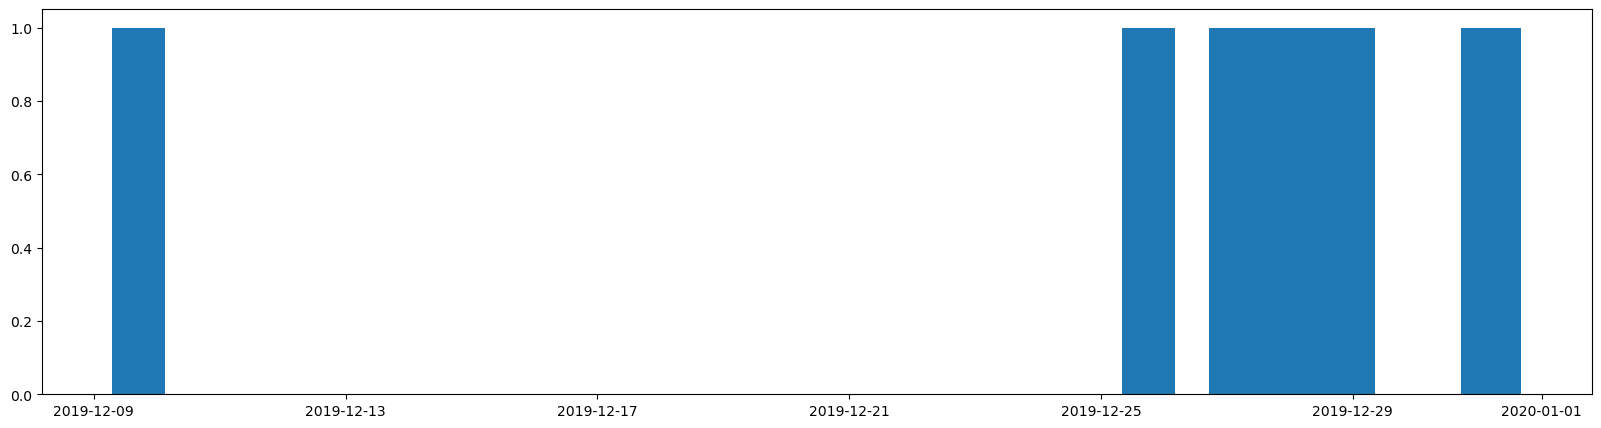

In [361]:
plt.figure(figsize=(20,5))
# plt.plot(L1.index, np.full(len(L1), 0))
plt.bar(L2[2000:5000][L2['avg_U'].isna()].index, np.full(len(L2[2000:5000][L2['avg_U'].isna()]), 1))

In [183]:
# таблицы характеристик третьих моментов по секторам
ma = 'lin_nt_str_001'

drop_max = '' #'1%' #'std3'  # метод фильтрации пиковых значений
min_ws = 0 # минимальная допустимая скорость ветра
nt_str = 0.01 # граница нейтральной стратификации

# проверяемая нулевая гипотеза
beta_0 = 1 
alfa_0 = 0
R_0 = 0 
alfa = False # использовать в уравнении свободный коэффициент 
a = 0.05 # граничное значение p-value

sn = ['Все направления','Ботанический сад','Метеорологическая площадка',
      'Здание обсерватории','Мичуринская аллея','Низкие деревья','Высокие деревья']

min_d = [  0, 0, 70,100,130,180,245]
max_d = [360,70,100,130,180,245,360]
# min_d, max_d, sn, ma = sector_boundaries(step=45, ma=ma) #разбитие на сектора с одинаковым шагом 

H = ['2.2','11.1','18.8']
lvl = [L1,L2,L3]

for h, L in zip(H, lvl): #цикл по высоте
    for j in ['WWT','WTT', 'WUU', 'WVV']: #цикл по моментам
        out_dir = f'/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/bar/{j}/' # папка, в котрую данные будут сохраняться
        file_name=f'{h}_{j}_{ma}_B{beta_0}_A{alfa_0}_R{R_0}_A{str(alfa)[0]}.csv'
        third_moments_table(L, f'{j}_th', f'{j}', 'Uh', 'dir_Uh', 'z/L', file_name,
                            out_dir, min_d, max_d, sn, nt_str, drop_max, min_ws, 
                            beta_0, alfa_0, R_0, alfa, a)   


In [369]:
L3['Tac'].mean()-L3['avg_T'].mean()

0.009816373737709938

In [370]:
L2['Tac'].mean()-L2['avg_T'].mean()

0.008936541562260203

In [373]:
(L2['Tac']-L2['avg_T']).mean()

0.008936541562261101

/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_93443/2774835744.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xticklabels)


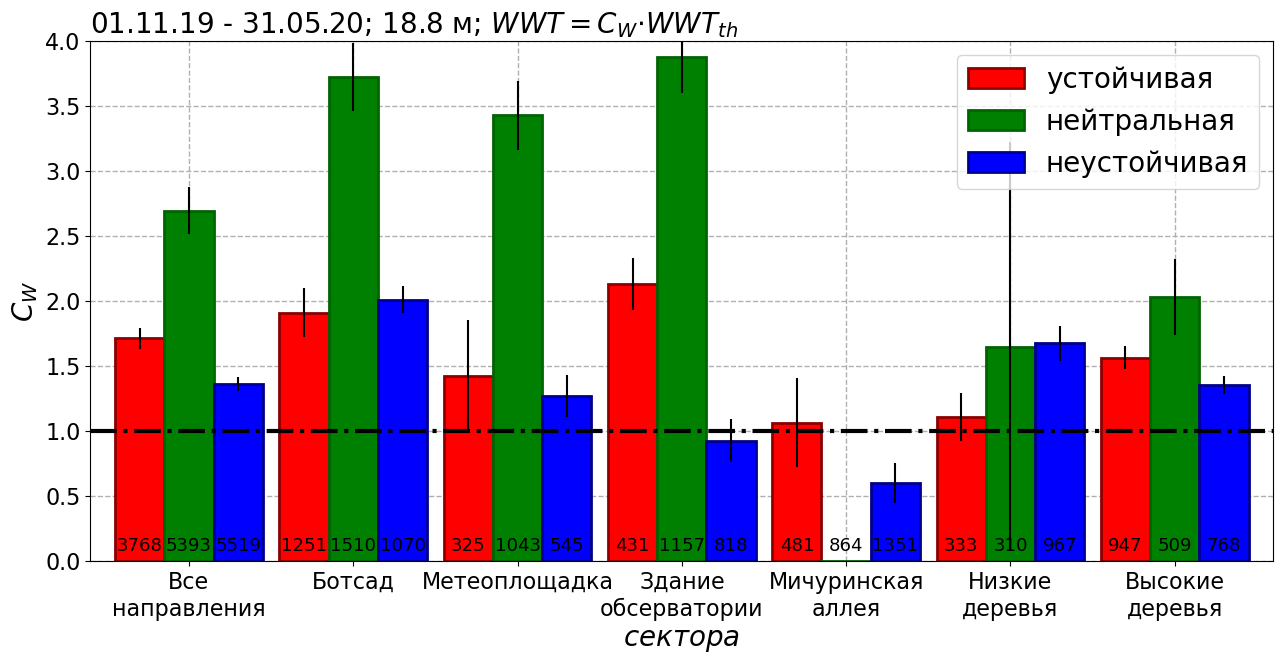

/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_93443/2774835744.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xticklabels)


<Figure size 640x480 with 0 Axes>

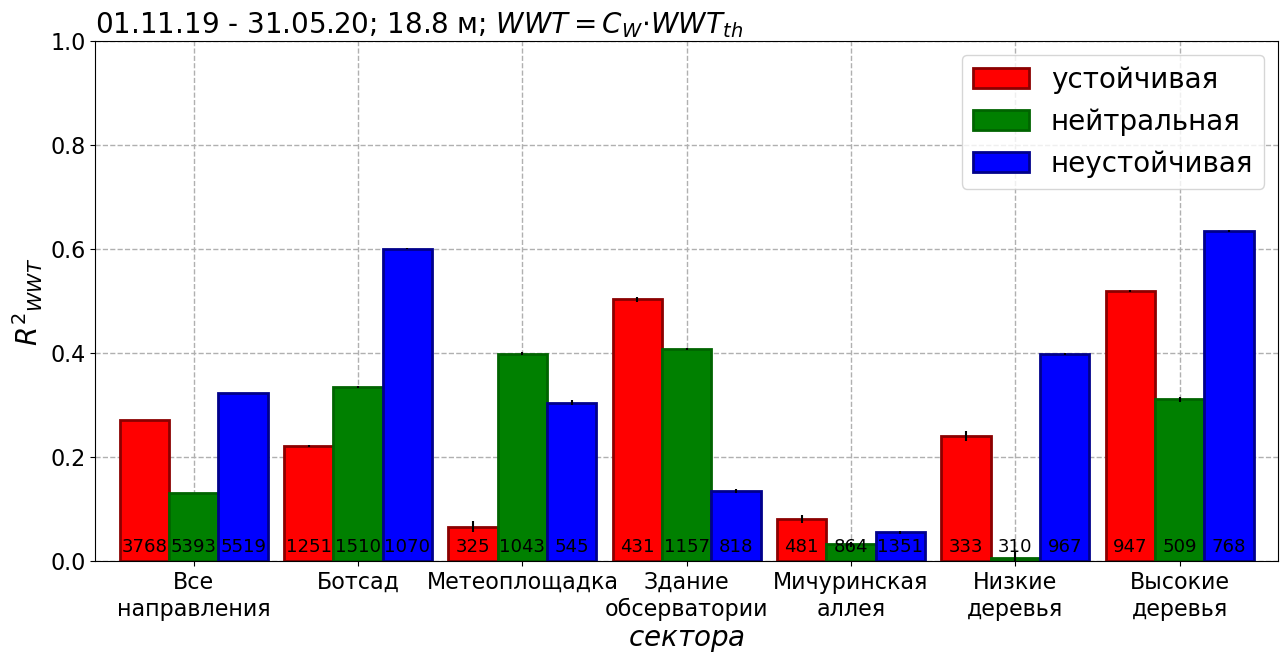

/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_93443/2774835744.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xticklabels)


<Figure size 640x480 with 0 Axes>

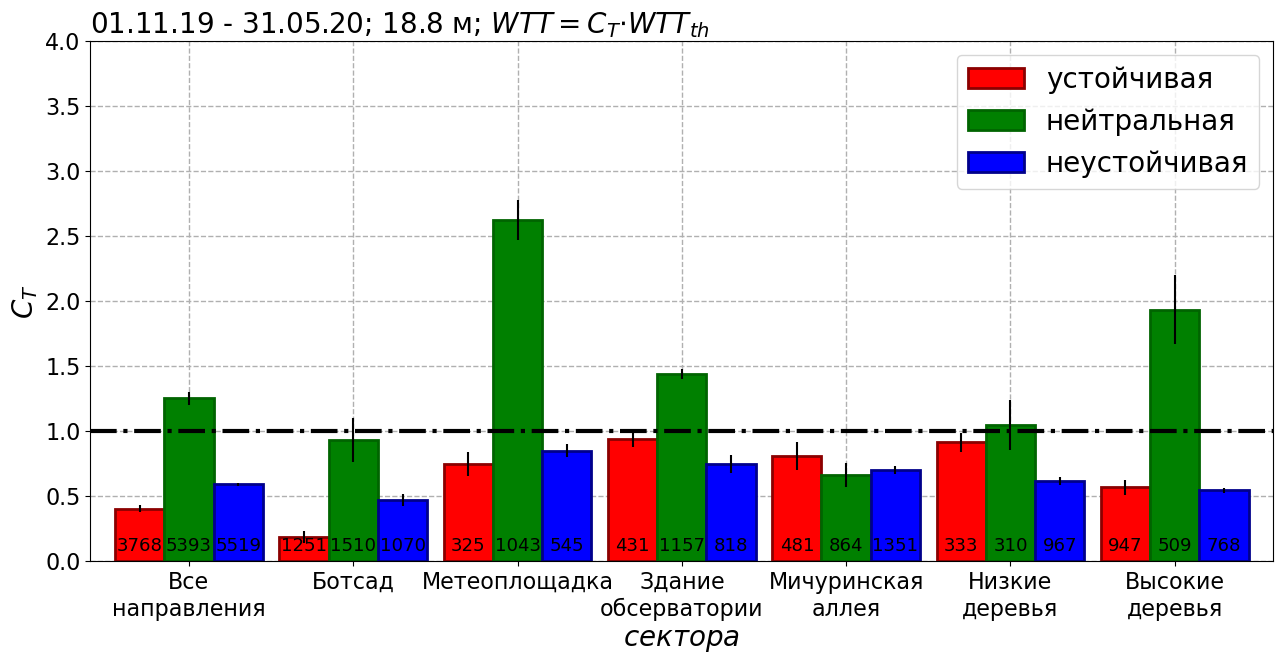

/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_93443/2774835744.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xticklabels)


<Figure size 640x480 with 0 Axes>

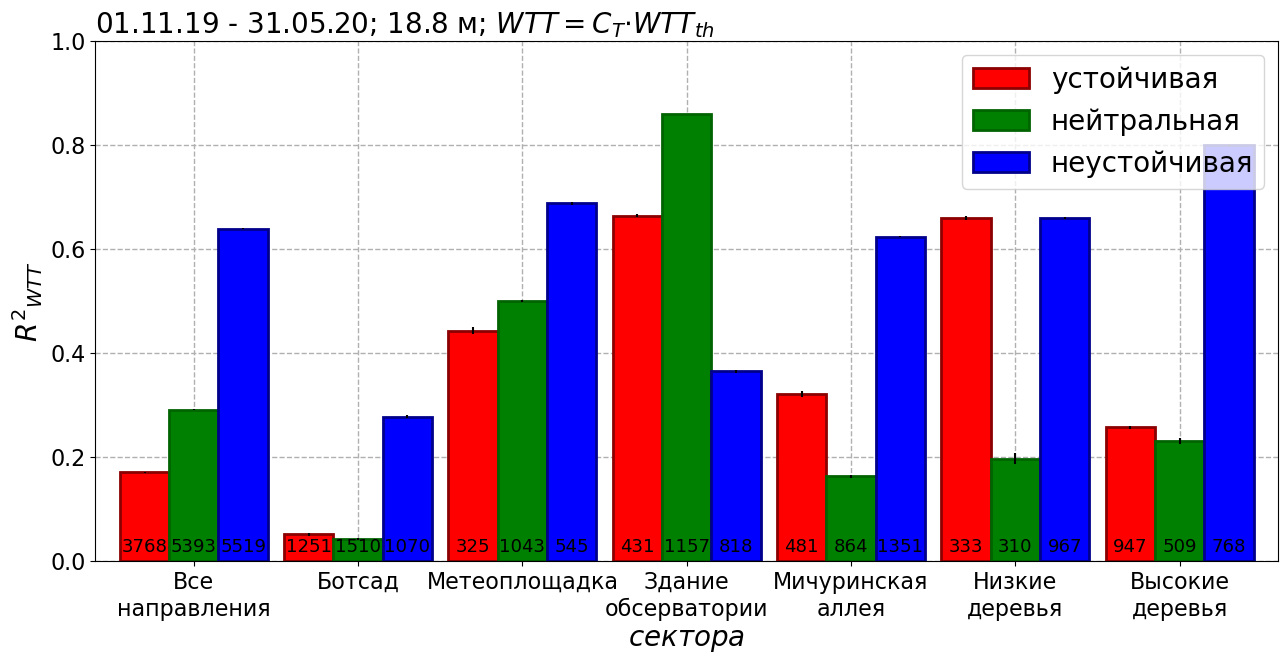

/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_93443/2774835744.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xticklabels)


<Figure size 640x480 with 0 Axes>

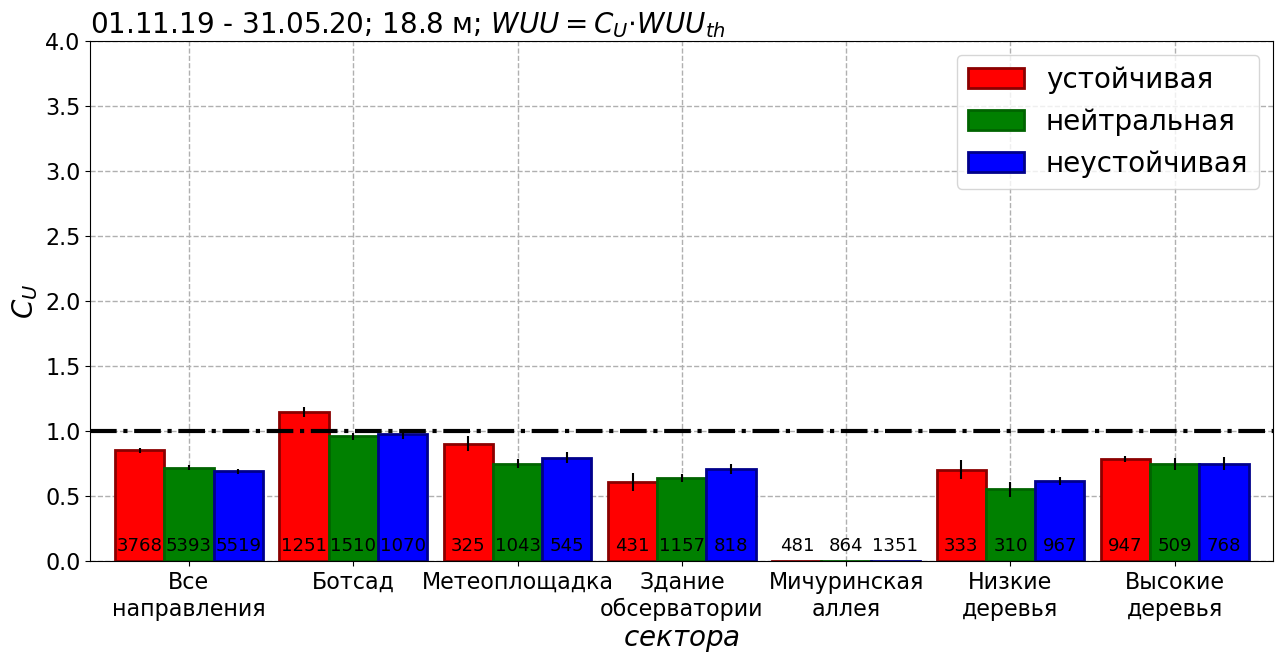

/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_93443/2774835744.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xticklabels)


<Figure size 640x480 with 0 Axes>

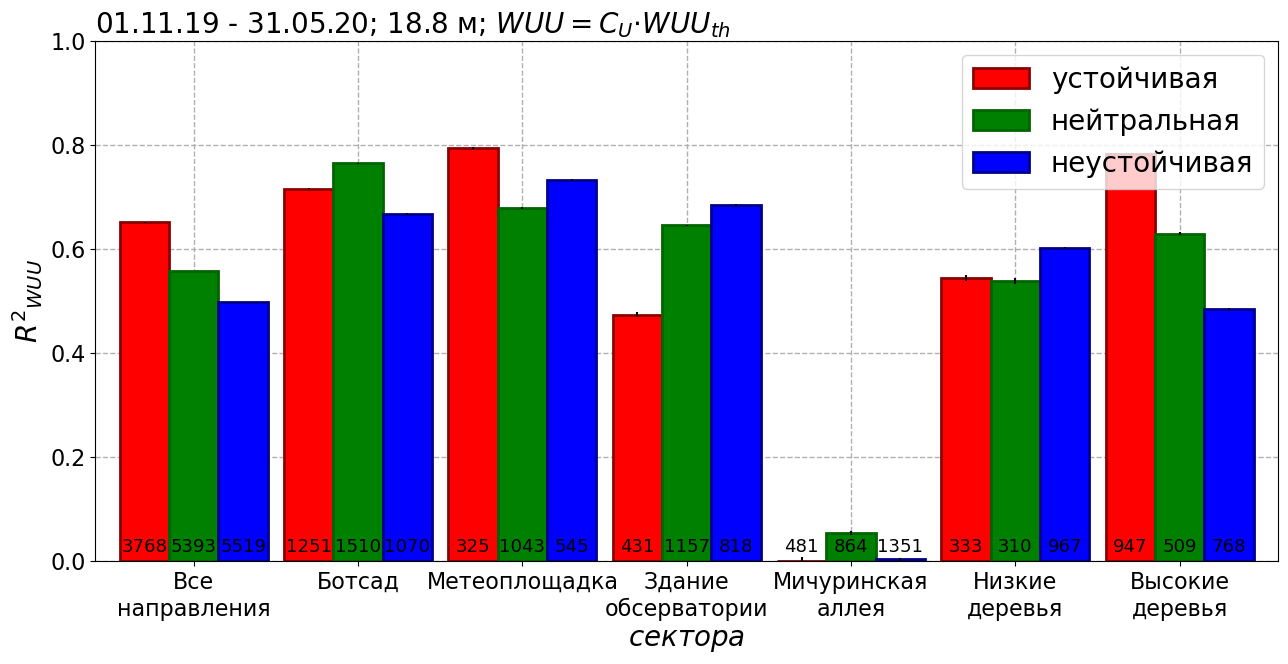

/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_93443/2774835744.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xticklabels)


<Figure size 640x480 with 0 Axes>

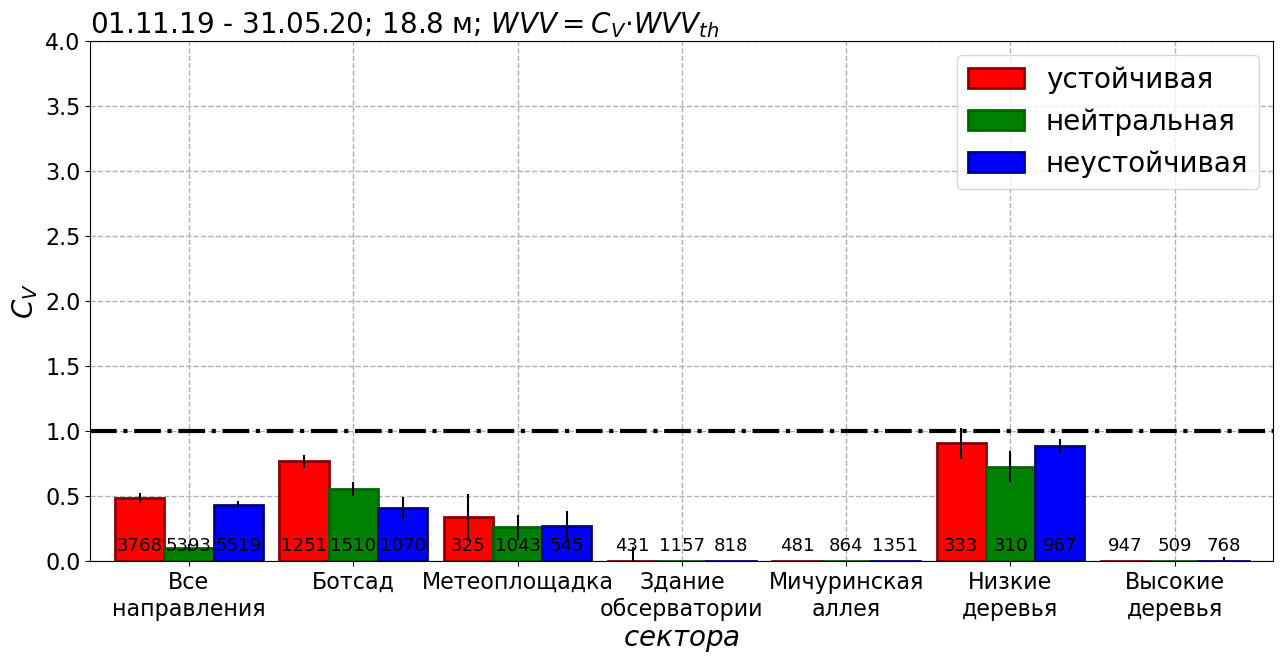

/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_93443/2774835744.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xticklabels)


<Figure size 640x480 with 0 Axes>

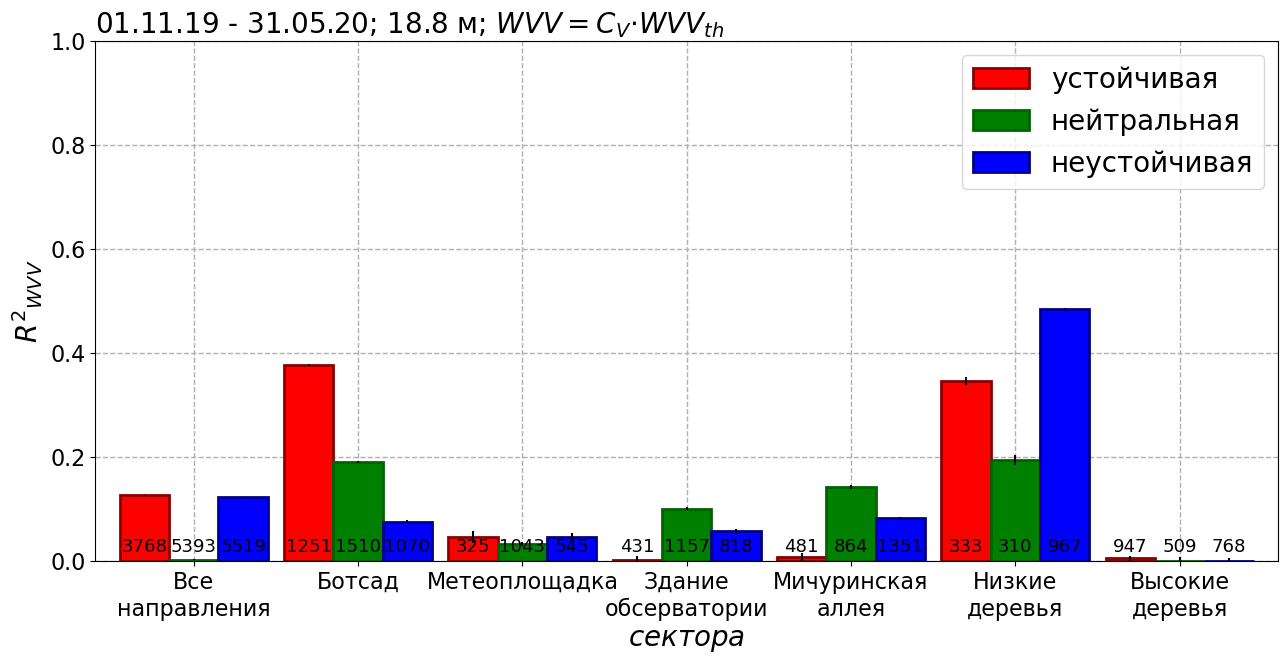

<Figure size 640x480 with 0 Axes>

In [308]:
#Столбчатые диаграммы
h = 18.8
ma = 'lin_nt_str_001'
# sn = ['All directions','Botanical\ngarden','Meteorological\nsite','Observatory\nbuilding','Michurinskaya\nalley','Low\ntrees','Tall\ntrees']
sn=['Все\nнаправления','Ботсад','Метеоплощадка',
    'Здание\nобсерватории','Мичуринская\nаллея','Низкие\nдеревья','Высокие\nдеревья']
#min_d, max_d, sn, ma = sector_boundaries(step=45, ma=ma) #разбитие на сектора с одинаковым шагом 
sn=['0']+sn

for i in ('WWT','WTT','WUU','WVV'):
    
    file_name=f'{h}_{i}_{ma}_B1_A0_R0_AF'
    out_dir=f'/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/bar/{i}/'
    
    if i=='WWT': Ci, Ri = '$_{W}$', '$_{WWT}$'
    if i=='WTT': Ci, Ri = '$_{T}$', '$_{WTT}$'
    if i=='WUU': Ci, Ri = '$_{U}$', '$_{WUU}$'
    if i=='WVV': Ci, Ri = '$_{V}$', '$_{WVV}$'
        
    th='$_{th}$'
    title=f'01.11.19 - 31.05.20; {h} м; ${i}=C${Ci}$ \cdot {i}${th}'#$y=C${Ci}$\cdot x+α$'
    
    tm=pd.read_csv(out_dir+f'{file_name}.csv')
    #tm.drop('Все направления',axis=1, inplace=True)
    tm.set_index('name',inplace=True)
    
    #коэффициенты детерминации и регреции, p-value
    R21, R22, R23 = tm[0:1].values[0], tm[1:2].values[0], tm[2:3].values[0]
    C1, C2, C3 = tm[3:4].values[0], tm[4:5].values[0], tm[5:6].values[0]
    p_val1, p_val2, p_val3 = tm[12:13].values[0], tm[13:14].values[0], tm[14:15].values[0]
    #длина ряда
    len1, len2, len3 = tm[51:52].values[0], tm[52:53].values[0], tm[53:54].values[0]
    
    #доверительные интервалы для R и С
    ciR21, ciR22, ciR23 = tm[18:19].values[0], tm[19:20].values[0], tm[20:21].values[0]
    ciC1, ciC2, ciC3 = tm[21:22].values[0], tm[22:23].values[0], tm[23:24].values[0]
    
    sector_bar(C1, C2, C3, ciC1, ciC2, ciC3, len1, len2, len3, out_dir, title=title, ylabel=f'$C${Ci}', 
               file_name=f'{file_name}_C.jpg', xticklabels=sn, ylim=[0,4], y_len=0.05, hip_0=1)
    
    sector_bar(R21, R22, R23, ciR21, ciR22, ciR23, len1, len2, len3, out_dir, title=title, ylabel=f'$R^2${Ri}',  
               file_name=f'{file_name}_R2.jpg', xticklabels=sn, ylim=[0,1], y_len=0.01)
    
#     sector_bar(p_val1, p_val2, p_val3, None, None, None, len1, len2, len3, out_dir, title=title, ylabel=f'$p$-$value$ {Ri}', 
#                file_name=f'{file_name}_p_val.jpg', xticklabels=sn, ylim=None, y_len=0, log=True, hip_0=0.01)


In [232]:
# отрисовка графиков по третьим моментам
papka = 'plot'  # папка, в котрую данные будут сохраняться
ma = 'lin_nt_str_001'
data = '01.11.19 - 31.05.20'
drop_max = '' #'1%','std3'
min_ws = 0
nt_str = 0.01
str_name = 'all_str' #'','stable','unstable','netrual'

# ylim = [-0.05,0.05]
# xlim = [-0.05,0.05]

beta_0=1
alfa_0=0
R_0=0 
alfa=False 
a=0.05

# sectors = ['$All$ $directions$','$Botanical$ $garden$','$Meteorological$ $site$',
#            '$Observatory$ $building$','$Michurinskaya$ $alley$','$Low$ $trees$','$Tall$ $trees$']

sectors = ['','Ботсад','Метеоплощадка','Здание обсерватории',
           'Мичуринская аллея','Низкие деревья','Высокие деревья']
min_ds=[  0, 0, 70,100,130,180,245]
max_ds=[360,70,100,130,180,245,360]
#min_d, max_d, sn, ma = sector_boundaries(step=45, ma=ma) #разбитие на сектора с одинаковым шагом 

lvl = [L1, L2, L3]
H = ['2.2', '11.1', '18.8']
colors = ['green', 'yellowgreen', 'lightgreen']

for L, h, c in zip(lvl, H, colors): # цикл по высоте    
    for min_d, max_d, sn in zip(min_ds, max_ds, sectors): # цикл по секторам
        title = f'{sn}\n{data}; {h} м'
        
        # WWT
        ylabel = "$\overline{W'W'T'},$ $°С \cdot м^2/с^2$"
        xlabel = "$\overline{W'W'T'}_{th},$ $°С \cdot м^2/с^2$"
        out_dir = f'/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/{papka}/WWT/'
        file_name = f'{h}_{sn}_WWT_{ma}_{str_name}_R{R_0}_B{beta_0}_A{alfa_0}{str(alfa)[0]}.jpg'

        third_moments_th(L, 'WWT_th', f'WWT', 'Uh', 'dir_Uh', 'z/L', 
                         str_name, nt_str, file_name, out_dir,
                         ylabel, xlabel, title, c, [-0.11,0.11], [-0.11,0.11],
                         drop_max, min_ws, min_d, max_d, 
                         beta_0, alfa_0, R_0, alfa, a)
        
        # WTT
        ylabel="$\overline{W'T'T'},$ $°С^2\cdot м/с$"
        xlabel="$\overline{W'T'T'}_{th},$ $°С^2\cdot м/с$"
        out_dir=f'/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/{papka}/WTT/'
        file_name=f'{h}_{sn}_WTT_{ma}_{str_name}_R{R_0}_B{beta_0}_A{alfa_0}{str(alfa)[0]}.jpg'

        third_moments_th(L, 'WTT_th', 'WTT', 'Uh', 'dir_Uh', 'z/L', 
                         str_name, nt_str, file_name, out_dir,
                         ylabel, xlabel, title, c, [-0.05,0.05], [-0.05,0.05],
                         drop_max, min_ws, min_d, max_d, 
                         beta_0, alfa_0, R_0, alfa, a)
        
        # WUU
        ylabel="$\overline{W'U'U'},$ $м^3/с^3$"
        xlabel="$\overline{W'U'U'}_{th},$ $м^3/с^3$"
        out_dir=f'/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/{papka}/WUU/'
        file_name=f'{h}_{sn}_WUU_{ma}_{str_name}_R{R_0}_B{beta_0}_A{alfa_0}{str(alfa)[0]}.jpg'

        third_moments_th(L, 'WUU_th', f'WUU', 'Uh', 'dir_Uh', 'z/L', 
                         str_name, nt_str, file_name, out_dir,
                         ylabel, xlabel, title, c, [-1.3,1.3], [-1.3,1.3],
                         drop_max, min_ws, min_d, max_d, 
                         beta_0, alfa_0, R_0, alfa, a)
        
        # WVV
        ylabel="$\overline{W'V'V'},$ $м^3/с^3$"
        xlabel="$\overline{W'V'V'}_{th},$ $м^3/с^3$"
        out_dir=f'/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/{papka}/WVV/'
        file_name=f'{h}_{sn}_WVV_{ma}_{str_name}_R{R_0}_B{beta_0}_A{alfa_0}{str(alfa)[0]}.jpg'

        third_moments_th(L, 'WVV_th', f'WVV', 'Uh', 'dir_Uh', 'z/L', 
                         str_name, nt_str, file_name, out_dir,
                         ylabel, xlabel, title, c, [-1.3,1.3], [-1.3,1.3],
                         drop_max, min_ws, min_d, max_d, 
                         beta_0, alfa_0, R_0, alfa, a)

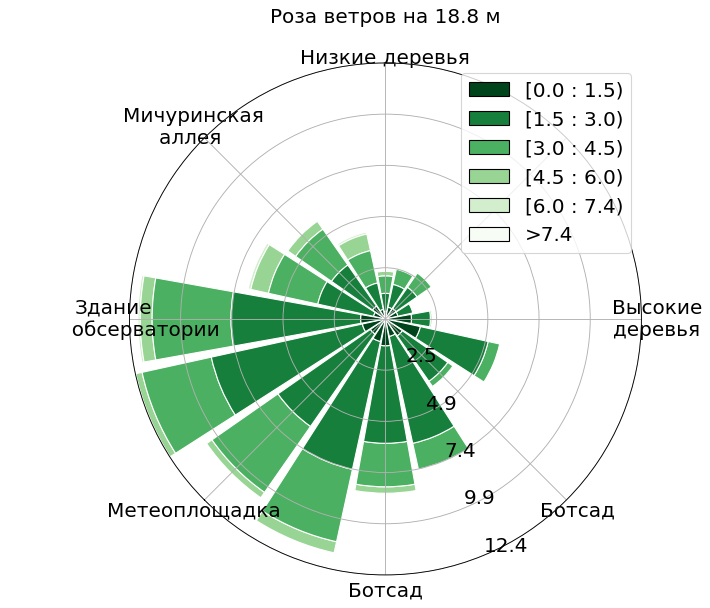

<Figure size 640x480 with 0 Axes>

In [221]:
# Построение роз ветров
# xticklabels=['Meteorological\nsite','Botanical garden','Botanical\ngarden','Tall\ntrees','Tall trees','\nLow trees','Michurinskaya\nalley ','Observ.\nbuilding']
xticklabels=['Метеоплощадка','Ботсад','Ботсад','Высокие\nдеревья','','\nНизкие деревья','Мичуринская\nаллея ','Здание\n          обсерватории']

h=18.8
wind_rose(ws=L3['Uh'],wd=L3['dir_Uh'], title=f'Роза ветров на {h} м', zero_location='SW',
          xticklabels=xticklabels, legend_loc='upper right', fale_name=f'/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/Wind_rose_tower_{h}.jpg')



In [19]:
# расчет статистических хар-к турбулентности за определенный месяц или за все время
meteo = pd.read_excel('/Users/ilyadrozd/Desktop/TOWER_DATA/DATA_OBS/meteo_2019_2020.xlsx', sheet_name='dd_mean', skiprows=4413, nrows=5112, names=['date (UTC)', 'Tair', 'Rel_hum', 'Pressure_station', 'wind_speed', 'Water_vapour_pressure', 'wind_dir']) 
smeteo = [0,   0,  720, 1464,2208,2904,3648,4368]
emeteo = [5112,720,1464,2208,2904,3648,4368,5112]
stime = ['2019-11-01','2019-11-01','2019-12-01','2020-01-01','2020-02-01','2020-03-01','2020-04-01','2020-05-01']
etime = ['2020-06-01','2019-12-01','2020-01-01','2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01']
months = ['all_time','November','December','January','February','March','April','May']
def turb_stat_lvl(H, mean, lvl, i_month, file_name):
    if i_month == 0:
        L = pd.read_csv(f'{data_directory}{lvl}/November/{file_name}', delimiter=',', skipinitialspace=True)
        for month in months[2:]:
            l = pd.read_csv(f'{data_directory}{lvl}/{month}/{file_name}', delimiter=',', skipinitialspace=True)
            L = pd.concat([L, l], ignore_index=True)
    else: 
        L = pd.read_csv(f'C:/TOWER_DATA/output/{lvl}/{months[i_month]}/{file_name}', delimiter=',', skipinitialspace=True)
  
    P = np.array([j for i in [[i]*(60//mean) for i in meteo['Pressure_station'][smeteo[i_month]:emeteo[i_month]]] for j in i])
    e = np.array([j for i in [[i]*(60//mean) for i in meteo['Water_vapour_pressure'][smeteo[i_month]:emeteo[i_month]]] for j in i])
       
    turb_moments = [ L[i] for i in L.columns.drop(['std_Uh','avg_W']) ] #
    
    ts = ['avg_T','Uh','dir_Uh','u_star','L','z/L','H','tau','TKE','A','WWT_th','WTT_th','WUU_th','WVV_th',
          'Sw','St','Su','Sv','Sw_th','St_th','Su_th','Sv_th']
    
    L = pd.concat([L,pd.DataFrame(turb_stat(H, P, e, *turb_moments),columns=ts)], axis=1)
    
    L['time'] = np.arange(stime[i_month],etime[i_month],np.timedelta64(mean, 'm'), dtype='datetime64[s]')

    L.set_index('time',inplace=True)
    
    return L

In [20]:
# расчет статистических хар-к на основе турбулентных моментов
def turb_stat(H, P, e, avg_U, avg_V, Tac, UU, VV, WW, TT, WU, WV, WT, WWT, WTT, WUU, WVV, WWW, TTT, UUU, VVV):
    
    # пересчет акустической температуры в реальную
    avg_T = Tac/(1+0.3192*e/P)
    avg_T = np.where(np.isnan(P)+np.isnan(e), Tac, avg_T)
    
    # модуль скорости ветра
    Uh = (avg_U**2+avg_V**2)**(1/2)
    
    # входные вектора показывают куда дует ветер.
    # V направлена на ГЗ (в сырых данных y).
    # U направлена на НИИ Белозеркого (в сырых данных x).
    # Север прибора направлен на ГЗ (135°).
    # На выходе направление откуда дует ветер.
    # Угол по ЧС от севера прибора.
    
    # направление ветра
    dir_Uh=180+np.floor(np.degrees(np.arctan2(avg_U,avg_V)))
    dir_Uh=np.where(dir_Uh==360, 0, dir_Uh)
        
    # ковариация горизонтальной и вертикальной скорости
    WUh=(WU**2+WV**2)**(1/2)
    u_star = WUh**(1/2)
    
    # масштаб МО            
    L_mo = -(avg_T+273.15)*WUh**(3/2)/(9.8*0.4*WT)
    dzeta = H/L_mo
    
    # расчет высоты погранслоя
    
    
    # расчет потоков с использованием данных метеостанции     
    H = 1030*P*100/(287*(avg_T+273.15))*WT
    tau = P*100/(287*(avg_T+273.15))*WUh

    # производные от вторых моментов
    TKE = (UU+VV+WW)/2
    A = WW/(UU+VV+WW)

    # коэффициенты асимметрии
    Sw = WWW/WW**(3/2)
    St = TTT/TT**(3/2)
    Su = UUU/UU**(3/2)
    Sv = VVV/VV**(3/2)
    
    # теоретические коэффициенты асимметерии
    Sw_th = WWT/(WT*WW**(1/2))
    St_th = WTT/(WT*TT**(1/2))
    Su_th = WUU/(WU*UU**(1/2))
    Sv_th = WVV/(WV*VV**(1/2))
    
    # теоретические третьи моменты
    WWT_th = Sw*WT*WW**(1/2)
    WTT_th = St*WT*TT**(1/2)
    WUU_th = Su*WU*UU**(1/2)
    WVV_th = Su*WV*VV**(1/2)
    
    return np.array([avg_T, Uh, dir_Uh, u_star, L_mo, dzeta, H, tau, TKE, A, 
                     WWT_th, WTT_th, WUU_th, WVV_th,
                     Sw, St, Su, Sv, Sw_th, St_th, Su_th, Sv_th]).T 

In [135]:
# границы секторов с равным шагом
def sector_boundaries(step, ma):
    sn_dig = []
    min_dig = np.arange(0,360,step)
    max_dig = np.arange(step,361,step)
    for i in range(len(min_dig)):
        sn_dig.append(f'{min_dig[i]}-{max_dig[i]}')
    ma_dig = ma+f'_dig{step}'
    return min_dig, max_dig, sn_dig, ma_dig

In [137]:
# таблицы статистических хар-к третьих моментов по секторам для разных условий стратификации
def third_moments_table(L, x, y, ws, wd, strat, file_name, out_dir, 
                         min_d, max_d, sn, nt_str=0.01, drop_max='', min_ws=0,
                        beta_0=0, alfa_0=0, R_0=0, alfa=True, a=0.05):   
    # названия строк DF    
    table = pd.DataFrame(['R2_st','R2_nt','R2_un',
                          'beta_st','beta_nt','beta_un',
                          'alfa_st','alfa_nt','alfa_un',
                          'p_R_st','p_R_nt','p_R_un',
                          'p_beta_st','p_beta_nt','p_beta_un',
                          'p_alfa_st','p_alfa_nt','p_alfa_un',
                          'conf_int_R2_st','conf_int_R2_nt','conf_int_R2_un',
                          'conf_int_beta_st','conf_int_beta_nt','conf_int_beta_un',
                          'conf_int_alfa_st','conf_int_alfa_nt','conf_int_alfa_un',
                          'mean_Xst','mean_Xnt','mean_Xun',
                          'mean_Yst','mean_Ynt','mean_Yun',
                          'std_Xst','std_Xnt','std_Xun',
                          'std_Yst','std_Ynt','std_Yun',
                          'min_Xst','min_Xnt','min_Xun',
                          'min_Yst','min_Ynt','min_Yun',
                          'max_Xst','max_Xnt','max_Xun',
                          'max_Yst','max_Ynt','max_Yun',
                          'len_st','len_nt','len_un'], columns=['name'])
    
    table.set_index('name', inplace=True)
    
    # Добавляем подпись в название файла, если используем дополнительные фильтры
    if min_ws > 0: file_name = f'min_ws_{min_ws}_'+file_name
    if drop_max == 'std3' or drop_max[-1:] == '%': file_name = f'{drop_max}_'+file_name
    
    L0 = L.dropna()  # убираем пропуски (далее L0 - весь DF (все данные с одного уровня), L - его часть для одного сектора)
    for k, sector in enumerate(sn):  # далее для каждого сектора рассчитываем статистические характеристики
        
        L = L0.loc[(L0[wd]>=min_d[k])&(L0[wd]<max_d[k])]  # убираем значения вне заданного сектора

        if min_ws > 0:
            L = L.loc[L[ws]>min_ws]  # убираем значения с маленькой скоростью ветра    

        if drop_max == 'std3':  # убираем значения превышающие три сигмы по x и y
            min_y, max_y = np.mean(L[y])-np.std(L[y])*3, np.mean(L[y])+np.std(L[y])*3
            min_x, max_x = np.mean(L[x])-np.std(L[x])*3, np.mean(L[x])+np.std(L[x])*3
            L = L.loc[(L[y]>min_y)&(L[y]<max_y)]
            L = L.loc[(L[x]>min_x)&(L[x]<max_x)]

        if drop_max[-1:] == '%':  # убираем N-% максимальных значений по x и y 
            N_drop = -round(int(drop_max[:-1])/100*len(L))  # число отбрасываемых значений
            max_y = L[y].values[np.argpartition(abs(L[y]), N_drop)[N_drop:N_drop+1]]  # фильтруем массив по возрастанию модуля до -N_drop и 
            max_x = L[x].values[np.argpartition(abs(L[x]), N_drop)[N_drop:N_drop+1]]  # запоминаем последний отфильтрованный элемент
            L = L.loc[(L[y]>-abs(max_y[0]))&(L[y]<abs(max_y[0]))]  # отбрасываем все, что больше по модулю
            L = L.loc[(L[x]>-abs(max_x[0]))&(L[x]<abs(max_x[0]))]
        
        # расчет статистических характеристик для различных случаев стратификации
        st, _ , _ = stratification('stable', L, x, y, strat, nt_str, beta_0, alfa_0, R_0, alfa, a)
        nt, _ , _ = stratification('neutral', L, x, y, strat, nt_str, beta_0, alfa_0, R_0, alfa, a)
        un, _ , _ = stratification('unstable', L, x, y, strat, nt_str, beta_0, alfa_0, R_0, alfa, a)
        
        # записываем все хар-ки в один столбец DF: st[0],nt[0],un[0], st[1],nt[1],un[1], ... st[n],nt[n],un[n]
        table[sector] = [j for i in [[st[i],nt[i],un[i]] for i in range(len(st))] for j in i] 
    
    # сохраняем DF в .csv
    table.to_csv(out_dir+file_name, na_rep='nan')

In [138]:
# расчет статистических хар-к для различных стратификаций
def stratification(str_name, L, x, y, strat, nt_str,
                   beta_0, alfa_0, R_0, alfa, a):
    if str_name == 'stable': L_str = L.loc[L[strat]>nt_str]
    elif  str_name == 'neutral': L_str = L.loc[(L[strat]<nt_str)&(L[strat]>-nt_str)]
    elif str_name == 'unstable': L_str = L.loc[L[strat]<-nt_str]
    else: L_str = L
    y = L_str[y]
    x = L_str[x]
    if len(x) >= 100:
        # R, p_r, ci_R, C, p_C, ci_C, A, p_A, ci_A
        stat = linreg_stat(x, y, beta_0, alfa_0, R_0, alfa, a)
        stat += [np.mean(x), np.mean(y), np.std(x), np.std(y), 
                 np.min(x), np.min(y), np.max(x), np.max(y)]
    else: stat = list(np.full(17, np.nan))
    return stat+[len(x)], x, y

In [140]:
#расчет коэффициентов регрессии, корреляции, доверительных интервалов, проверка 0-х гипотез для R, beta, alfa.
def linreg_stat(x, y, beta_0=0, alfa_0=0, R_0=0, alfa=True, a=0.05):
    n = len(x) #размер выборки
    
    if alfa: #y=beta*x+alfa
        beta_hat = np.sum((x-np.mean(x))*(y-np.mean(y)))/np.sum((x-np.mean(x))*(x-np.mean(x))) #slope по наблюдениям
        alfa_hat = np.mean(y)-beta_hat*np.mean(x) #intersept по наблюдениям
    else:  #y=beta*x
        beta_hat = np.mean(x*y)/np.mean(x*x)
        alfa_hat = 0
    
    SSR = np.sum((y-(alfa_hat+beta_hat*x))**2) #sum(epsilon_hat**2) epsilon_hat=y-y_hat, sum of squared residual
    MSE = SSR/(n-2) #sigma_epsilon_hat**2, mean squere error

    se_beta_hat = np.sqrt(MSE/np.sum((x-np.mean(x))**2)) #standard error of beta
    t_val_beta = (beta_hat-beta_0)/se_beta_hat #t-value (beta)
    p_val_beta = 1-(stats.t.cdf(abs(t_val_beta), n-2)-stats.t.cdf(-abs(t_val_beta), n-2)) #p-value (beta)
    
    se_alfa_hat = se_beta_hat*np.sqrt(np.mean(x**2)) #standard error of alfa
    t_val_alfa = (alfa_hat-alfa_0)/se_alfa_hat #t-value (alfa)
    p_val_alfa = 1-(stats.t.cdf(abs(t_val_alfa), n-2)-stats.t.cdf(-abs(t_val_alfa), n-2)) #p-value (alfa)
    
    R = (np.mean(x*y)-np.mean(x)*np.mean(y))/np.sqrt((np.mean(x**2)-np.mean(x)**2)*(np.mean(y**2)-np.mean(y)**2))
    #p_val_r_1=2*stats.beta(n/2-1, n/2-1, loc=-1, scale=2).cdf(-abs(R))
    se_R = np.sqrt(1-R**2)/np.sqrt(n-2) #standard error of R
    t_val_r = (R-R_0)/se_R #t-value (R) = t-value (beta) при нулевой гипотезе "отсутствие корреляции" 
    p_val_r = 1-(stats.t.cdf(abs(t_val_r), n-2)-stats.t.cdf(-abs(t_val_r), n-2)) #p-value (R) = p-value (beta), если R_0=0 и beta_0=0  
    
    t_a = abs(stats.t.ppf(a/2, n-2)) #значение t-value при вероятности a/2 по t-распределению с n-2 степенями свободы  
    conf_int_beta = t_a*se_beta_hat #доверительный интервал для beta
    conf_int_alfa = t_a*se_alfa_hat #доверительный интервал для alfa
    conf_int_R = t_a*se_R #доверительный интервал для R
    
    return  [R**2, beta_hat, alfa_hat, p_val_r, p_val_beta, p_val_alfa, conf_int_R**2, conf_int_beta, conf_int_alfa]


    se_beta_hat = np.sqrt(MSE/np.sum((x-np.mean(x))**2)) #standard error of beta
    se_R = np.sqrt(1-R**2)/np.sqrt(n-2) #standard error of R
    
    t_a = abs(stats.t.ppf(a/2, n-2)) #значение t-value при вероятности a/2 по t-распределению с n-2 степенями свободы  
    conf_int_beta = t_a*se_beta_hat #доверительный интервал для beta
    conf_int_R = t_a*se_R #доверительный интервал для R


In [307]:
# столбчатые диаграммы по таблицам хар-к третьих моментов
def sector_bar(y1,y2,y3, conf_int1, conf_int2, conf_int3, len1, len2, len3, out_dir,
               title, ylabel, file_name, xticklabels, ylim, y_len, log=False, hip_0=None):
    
    x1 = np.arange(len(y1))-0.3
    x2 = np.arange(len(y2))
    x3 = np.arange(len(y3))+0.3
    
    fig1, ax1 = plt.subplots(figsize=(13, 6.5))
    
    if hip_0: ax1.plot(np.linspace(-0.6, len(x2)+0.6, 100), np.linspace(hip_0, hip_0, 100), color='k', linestyle='-.', linewidth=3, zorder=3)
    
    ax1.bar(x1, y1, yerr=conf_int1, width=0.3, color='r', ec='darkred', lw=2, label='устойчивая', log=log, zorder=2)
    ax1.bar(x2, y2, yerr=conf_int2, width=0.3, color='g', ec='darkgreen', lw=2, label='нейтральная', log=log, zorder=2)
    ax1.bar(x3, y3, yerr=conf_int3, width=0.3, color='b', ec='darkblue', lw=2, label='неустойчивая', log=log, zorder=2)
    
    ax1.grid(zorder=0, lw=1, linestyle='--')
    ax1.legend(loc='upper right', fontsize=20)
    ax1.set_xticklabels(xticklabels)
    ax1.tick_params(axis='both', labelsize=16)
    ax1.set_title(title, loc='left', fontsize=20)
    ax1.set_ylabel(ylabel, fontsize=20)
    ax1.set_ylim(ylim)
    ax1.set_xlim([-0.6, len(x2)-1+0.6])
    ax1.set_xlabel('$сектора$',fontsize=20)
         
    for i, x in enumerate(x2):
        ax1.text(x-0.3, y_len, '%i'%len1[i], ha='center', va='bottom', fontsize=13)
        ax1.text(x, y_len, '%i'%len2[i], ha='center', va='bottom', fontsize=13)
        ax1.text(x+0.3, y_len, '%i'%len3[i], ha='center', va='bottom', fontsize=13)
    
    plt.subplots_adjust(left=0.07, bottom=0.14, right=0.98, top=0.94)
    plt.savefig(out_dir+file_name)
    plt.show()
    plt.clf()

In [225]:
# диаграммы рассеяния для третьих моментов с линейной регрессией, доверительными интервалами и оценкой значимости тренда
def third_moments_th(L, x, y, ws, wd, strat, str_name, nt_str,
                     file_name, out_dir, ylabel, xlabel, title, color,
                     xlim, ylim, drop_max='', min_ws=0, min_d=0, max_d=360,
                     beta_0=0, alfa_0=0, R_0=0, alfa=True, a=0.05):           
    L = L.dropna()
    L = L.loc[(L[wd]>=min_d)&(L[wd]<max_d)]  # убираем значения вне заданного сектора

    # убираем значения с маленькой скоростью ветра  
    if min_ws > 0:
        L = L.loc[L[ws]>min_ws]    
        file_name = f'min_ws_{min_ws}_'+file_name
    
    # убираем значения больше 3.5 стандартных отклонений
    if drop_max == 'std3':
        min_y, max_y = np.mean(L[y])-np.std(L[y])*3.5, np.mean(L[y])+np.std(L[y])*3.5
        min_x, max_x = np.mean(L[x])-np.std(L[x])*3.5, np.mean(L[x])+np.std(L[x])*3.5

        L = L.loc[(L[y]>min_y)&(L[y]<max_y)]
        L = L.loc[(L[x]>min_x)&(L[x]<max_x)]
        file_name = f'{drop_max}_'+file_name      
    
    # убираем 1% максимальных значений
    if drop_max[-1:] == '%':
        N_drop = -round(int(drop_max[:-1])/100*len(L))  # число отфильтровываемых значений
        max_y = L[y].values[np.argpartition(abs(L[y]), N_drop)[N_drop:N_drop+1]]  # фильтрует массив по возрастанию модуля до -N_drop, 
        max_x = L[x].values[np.argpartition(abs(L[x]), N_drop)[N_drop:N_drop+1]]  # запоминаем последний отфильтрованный элемент

        L = L.loc[(L[y]>-abs(max_y[0]))&(L[y]<abs(max_y[0]))]
        L = L.loc[(L[x]>-abs(max_x[0]))&(L[x]<abs(max_x[0]))]
        file_name = f'{drop_max}_'+file_name      
     
    fig2, ax2 = plt.subplots(figsize=(25, 20))
    
    # строим графики для всех типов стратификации
    if str_name == 'all_str': 
        un, x_un, y_un = stratification('unstable', L, x, y, strat, nt_str, beta_0, alfa_0, R_0, alfa, a)
        nt, x_nt, y_nt = stratification('neutral', L, x, y, strat, nt_str, beta_0, alfa_0, R_0, alfa, a)
        st, x_st, y_st = stratification('stable', L, x, y, strat, nt_str, beta_0, alfa_0, R_0, alfa, a)
        
        ax2.scatter(x_un, y_un, facecolor='none', edgecolors = 'blue', label='', s=8, linewidth=12, alpha=0.75)
        ax2.scatter(x_nt, y_nt, facecolor='none', edgecolors = 'green', label='', s=8, linewidth=12, alpha=0.75)
        ax2.scatter(x_st, y_st, facecolor='none', edgecolors = 'red', label='', s=8, linewidth=12, alpha=0.75)
        
        text = ''
        if un[17] > 100: 
            ax2, text_un = plot_linreg(ax2, un, x_un, y_un, a, f' ${strat}<-{nt_str}$', 'darkblue', 'un')
            text += f'{text_un}'
        if nt[17] > 100:
            ax2, text_nt = plot_linreg(ax2, nt, x_nt, y_nt, a, f' $-{nt_str} \leqslant {strat} \leqslant {nt_str}$', 'darkgreen', 'nt')
            text += f'\n{text_nt}'
        if st[17] > 100:
            ax2, text_st = plot_linreg(ax2, st, x_st, y_st, a, f' ${strat}>{nt_str}$', 'darkred', 'st')
            text += f'\n{text_st}' 
    else: 
        one_strat, x, y = stratification(str_name, L, x, y, strat, nt_str, beta_0, alfa_0, R_0, alfa, a)
        ax2.scatter(x, y, facecolor='none', edgecolors = color, label='', s=4, linewidth=8, alpha=0.5)
        ax2, text = plot_linreg(ax2, one_strat, x, y, a, '', 'k')
    
    # отрисовка нулевой гипотезы y=x
#     x0 = np.linspace(L[x].min(),L[x].max(),1000)
#     ax2.plot(x0, x0, color='gray', label='$Hypothesis$ $%3s=%3s_{th}$'%(y,y), linestyle='--', linewidth=6) 
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.5)
    ax2.text(0.2, 0.05, text, fontsize=60, transform=ax2.transAxes, bbox=props)
    
    ax2.legend(loc='upper left', fontsize=50)
    ax2.grid(linewidth=4, linestyle='--')
    ax2.tick_params(axis='both', labelsize=75)
    ax2.set_title(title, fontsize=75, loc='left')
    ax2.set_xlabel(xlabel,fontsize=75)
    ax2.set_ylabel(ylabel,fontsize=75)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    plt.subplots_adjust(left=0.2, bottom=0.13, right=0.96, top=0.88)
    plt.savefig(out_dir+file_name)
#     plt.show()
    plt.clf()
    plt.close()
    

In [207]:
# отрисовка линии регрессии, доверительных интервалов, R2, p-value
# 0 R, 1 C, 2 A, 3 p_r, 4 p_C, 5 p_A, 6 ci_R, 7 ci_C, 8 ci_A,
# 9 np.mean(x), 10 np.mean(y), 11 np.std(x), 12 np.std(y), 
# 13 min(x),  14 min(y), 15 max(x), 16 max(y), 17 len(x) - элементы массива s (st, un, nt) и их индексы 
        
def plot_linreg(ax, s, x_s, y_s, a, text_strat, clr, ns):                 
    x1 = np.linspace(s[13],s[15],1000)  # x для линий регрессий и доверительных интервалов
    
    if s[2] == 0:  # смотрим какую регрессию нужно отобразить 
        ax.plot(x1, x1*s[1], label='$y=%.2fx,$'%(s[1])+text_strat, color=clr, linestyle='-.', linewidth=6)
        ax.fill_between(x1, x1*(s[1]-s[7]), x1*(s[1]+s[7]), color=clr, alpha=0.25, linewidth=2)
    else:
        ax.plot(x1, x1*s[1]+s[2], label='$y=%.2fx \pm %.2f,$'%(s[1],abs(s[2]))+text_strat, color=clr, linestyle='-.', linewidth=6)
        y_e = y_err(x1, x_s, y_s, s[1], s[2], a)  # расчет гиперболического доверительного интервала
        ax.fill_between(x1, x1*s[1]+s[2]-y_e, x1*s[1]+s[2]+y_e, color=clr, alpha=0.25, linewidth=2)
    
    p_v = '%.2E'%(s[4])  # переписываем p-value в другой формат для красивого вывода
    ci_R2 = '%.2E'%(s[6])
    text='$R^2{}_{%2s}=%.2f \pm %1s \cdot 10^{%3s},$ $p=%1s \cdot 10^{%3s}$'%(ns,s[0],ci_R2[:1],ci_R2[-3:],p_v[:1],p_v[-3:])
    
    return ax, text

In [208]:
# расчет доверительного интервала для y=beta*x+alfa
def y_err(x, x_st, y_st, beta, alfa, a):
    n = len(x_st)
    SSR = np.sum((y_st-(alfa+beta*x_st))**2)  # sum(epsilon_hat**2) epsilon_hat=y-y_hat, sum of squared residual
    MSE = SSR/(n-2)  # sigma_epsilon_hat**2, mean squere error
    t_a = abs(stats.t.ppf(a/2, n-2))
    return t_a*np.sqrt(MSE*(1/n+(x-np.mean(x_st))**2/np.sum((x_st-np.mean(x_st))**2)))

In [127]:
# построение роз ветров
def wind_rose(ws, wd, title, zero_location, xticklabels, legend_loc, fale_name):
    ax3 = wr.WindroseAxes.from_ax()
    ax3.bar(wd,ws,normed=True, opening=0.9, edgecolor='white', cmap=plt.cm.Greens_r)
    ax3.set_title(title, fontsize=18, pad=0)
    plt.legend(loc=legend_loc, fontsize=18)
    ax3.set_xticklabels(xticklabels)
    ax3.tick_params(axis='x', labelsize=18)
    ax3.tick_params(axis='y', labelsize=18)
    #ax3.set_theta_direction('clockwise')
    ax3.set_theta_zero_location(zero_location)
    plt.savefig(fale_name)
    plt.show()
    plt.clf()

In [236]:
determ_coef = lambda x, y: ((np.mean(x*y)-np.mean(x)*np.mean(y))/np.sqrt((np.mean(x**2)-np.mean(x)**2)*(np.mean(y**2)-np.mean(y)**2)))**2
reg_coef = lambda x, y: np.mean(x*y)/np.mean(x*x)

def strat_bootstrap(str_name, L, x, y, strat, nt_str,
                   beta_0, alfa_0, R_0, alfa, a):
    if str_name == 'stable': L_str = L.loc[L[strat]>nt_str]
    elif  str_name == 'netrual': L_str = L.loc[(L[strat]<nt_str)&(L[strat]>-nt_str)]
    elif str_name == 'unstable': L_str = L.loc[L[strat]<-nt_str]
    else: L_str = L
    y = L_str[y]
    x = L_str[x]
    
    C, R2 = bootstrap(x, y, n=10000, size=0.1)
    g_R2_st = determ_coef(L_st[x], L_st[y])
    g_C_st = reg_coef(L_st[x], L_st[y])
    

In [237]:
def bootstrap(x, y, n=10000, size=0.1):
    len_L=len(x)
    sample_size=int(len_L*size)
        
    R2=np.zeros(n)
    C=np.zeros(n)
    
    for i in range(n):
        indices = np.random.choice(np.arange(len_L), replace=False, size=sample_size)
        sample_x=x.iloc[indices]
        sample_y=y.iloc[indices]

        R2[i] = determ_coef(sample_x, sample_y)
        C[i] = reg_coef(sample_x, sample_y)
    
    return C, R2


In [238]:
def bootstrap_hist(ax, x, name, g_x, g_ci_x, str_name, clr):  
    ax.hist(x, bins=100, density=True, histtype='step', label=name+'$_{bs}$ '+str_name, color=clr, linewidth=8)
    x1 = np.linspace(g_x-g_ci_x, g_x+g_ci_x, 100)
    y1 = np.linspace(0, 0, 100)
    y2 = np.linspace(100, 100, 100)
    ax.fill_between(x1, y1, y2, color='dark'+clr, alpha=0.25, linewidth=2)
    ax.plot(np.linspace(g_x,g_x,100), np.linspace(0,100,100), color='dark'+clr, linewidth=6, linestyle='-.', label=name+'$_{ls}$ '+str_name)
    
    return ax

In [288]:
L = L3.dropna()
h = '18.8'
strat = 'z/L'
nt_str = 0.01
x = 'WWT_th'
y = 'WWT'

L_st = L.loc[L[strat]>nt_str]
L_nt = L.loc[(L[strat]<nt_str)&(L[strat]>-nt_str)]
L_un = L.loc[L[strat]<-nt_str]

C_st, R2_st = bootstrap(L_st[x], L_st[y], n=10000, size=0.1)
C_nt, R2_nt = bootstrap(L_nt[x], L_nt[y], n=10000, size=0.1)
C_un, R2_un = bootstrap(L_un[x], L_un[y], n=10000, size=0.1)

stat = linreg_stat(L_st[x], L_st[y], beta_0=1, alfa_0=0, R_0=0, alfa=False, a=0.05)
gR2_st = stat[0]
gC_st = stat[1]
gci_R2_st = stat[6]
gci_C_st = stat[7]

stat = linreg_stat(L_nt[x], L_nt[y], beta_0=1, alfa_0=0, R_0=0, alfa=False, a=0.05)
gR2_nt = stat[0]
gC_nt = stat[1]
gci_R2_nt = stat[6]
gci_C_nt = stat[7]

stat = linreg_stat(L_un[x], L_un[y], beta_0=1, alfa_0=0, R_0=0, alfa=False, a=0.05)
gR2_un = stat[0]
gC_un = stat[1]
gci_R2_un = stat[6]
gci_C_un = stat[7]


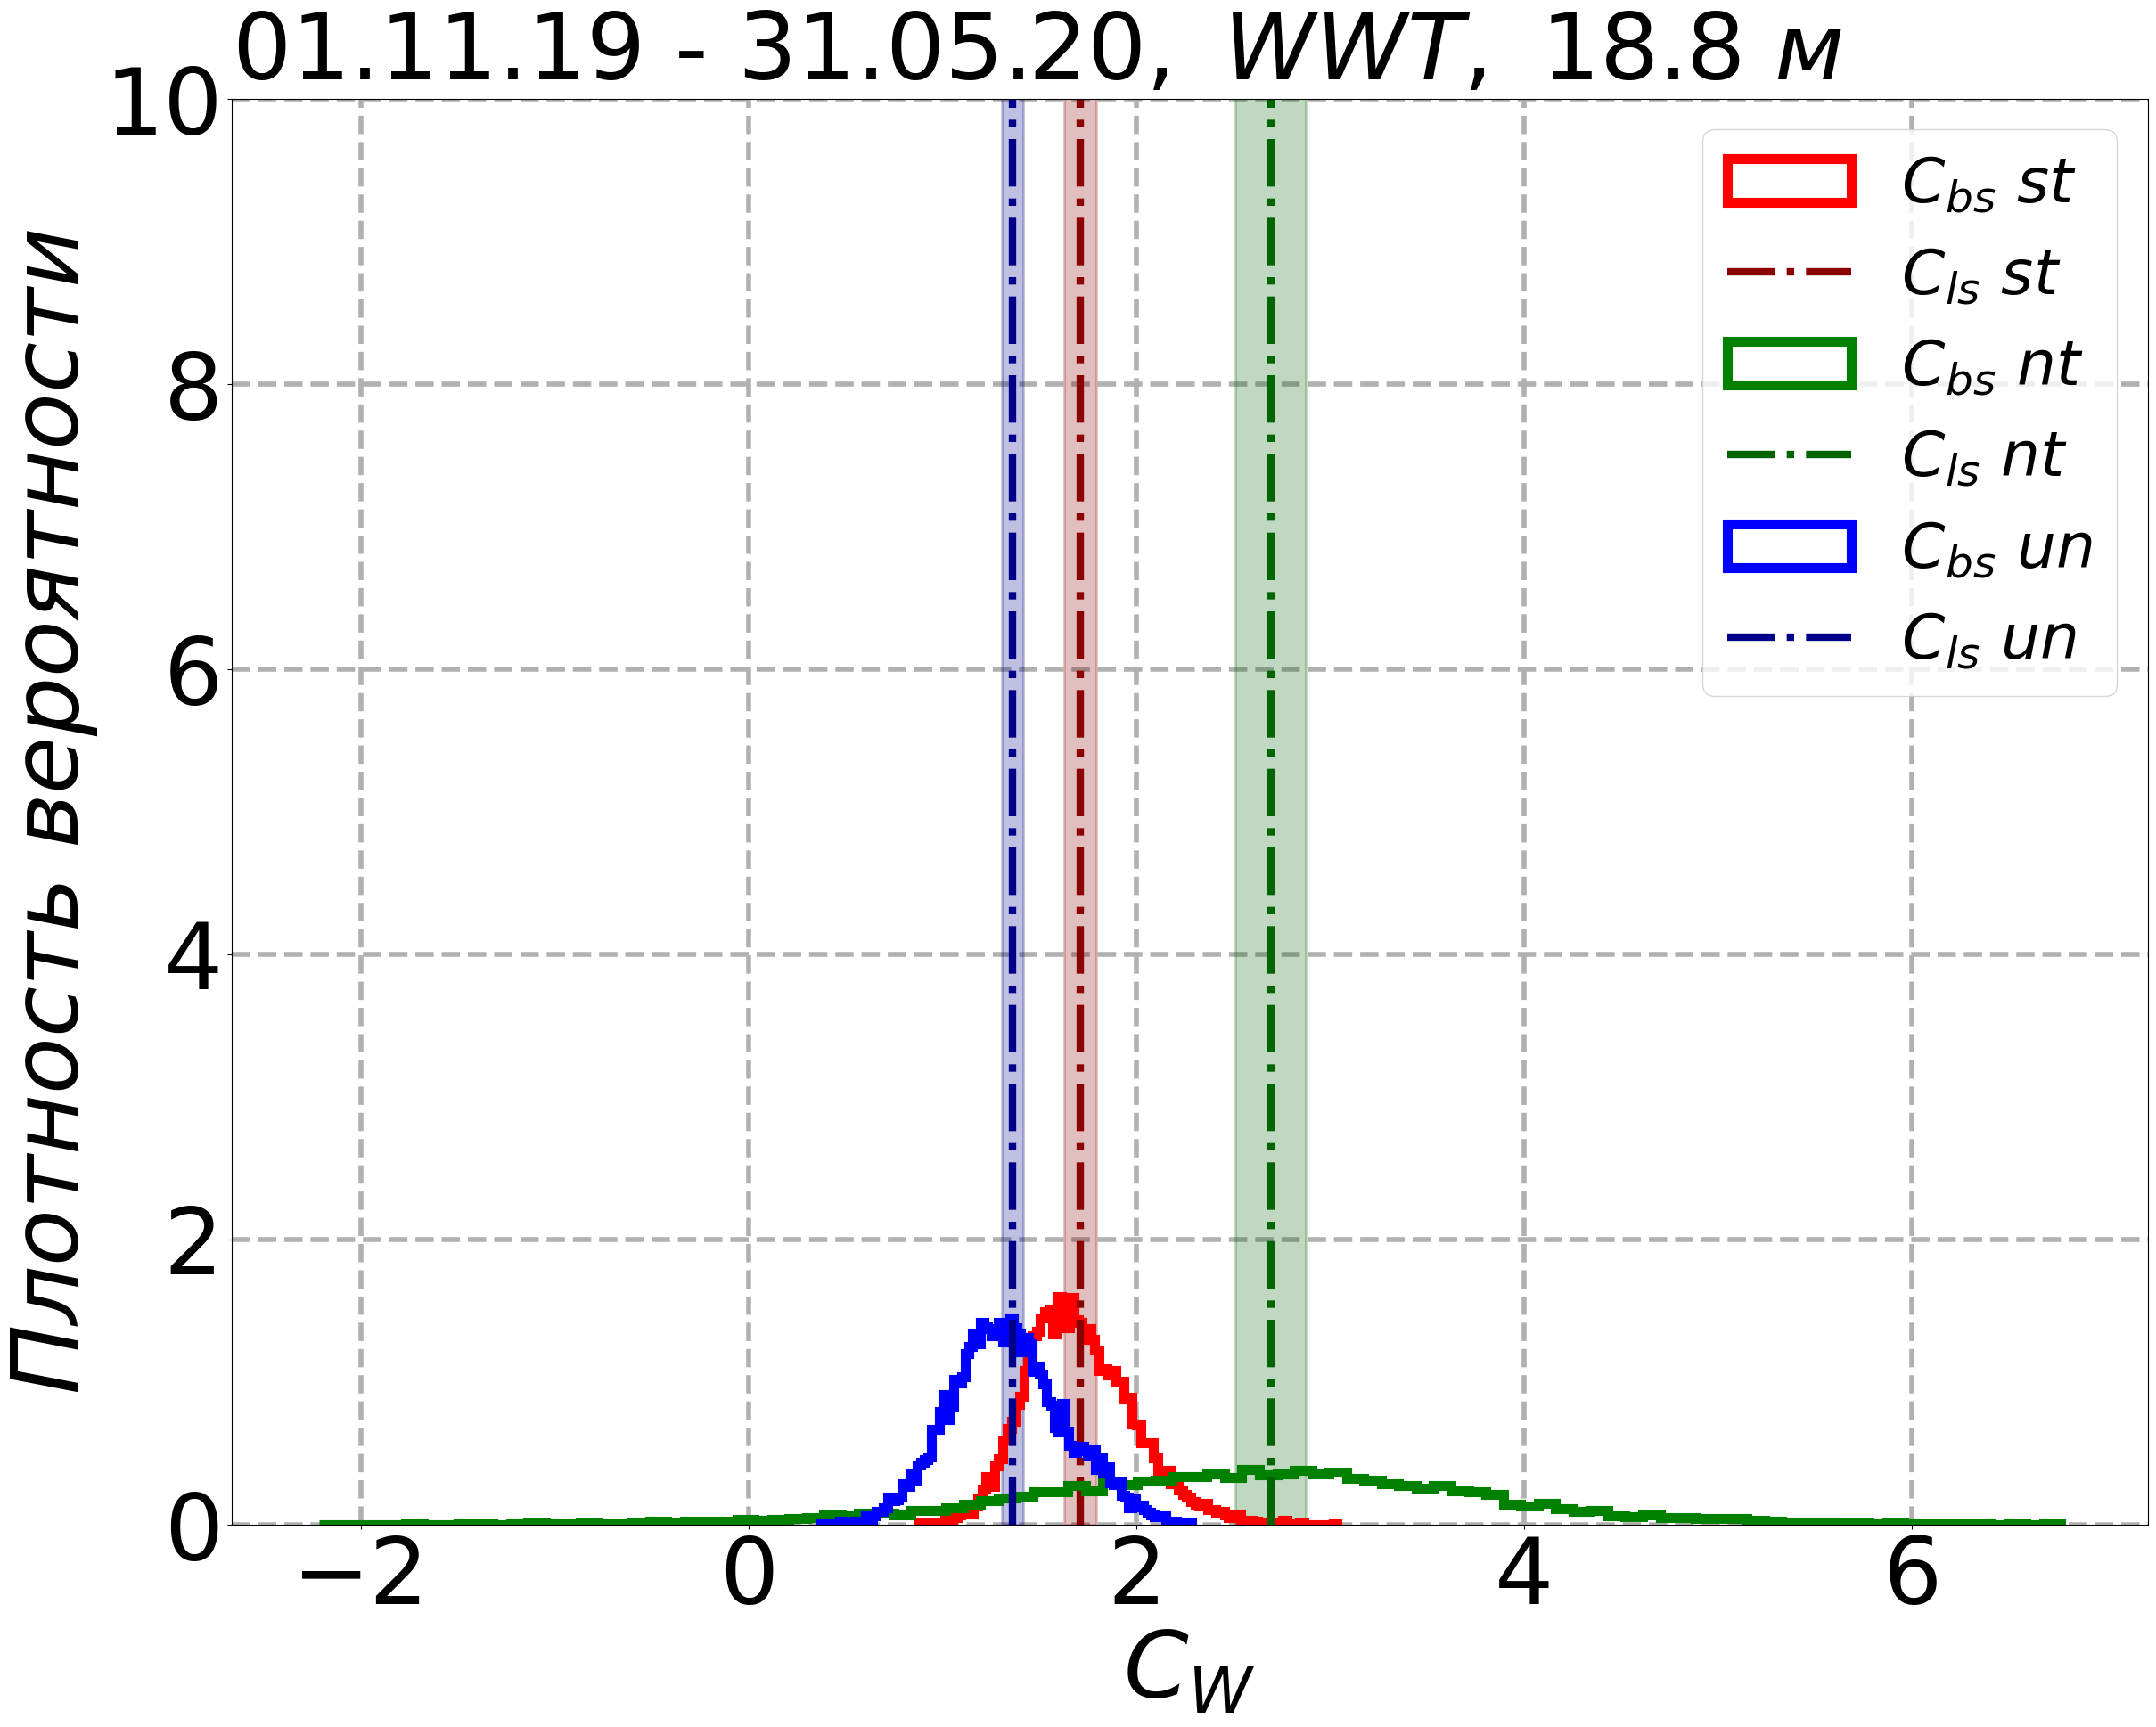

<Figure size 640x480 with 0 Axes>

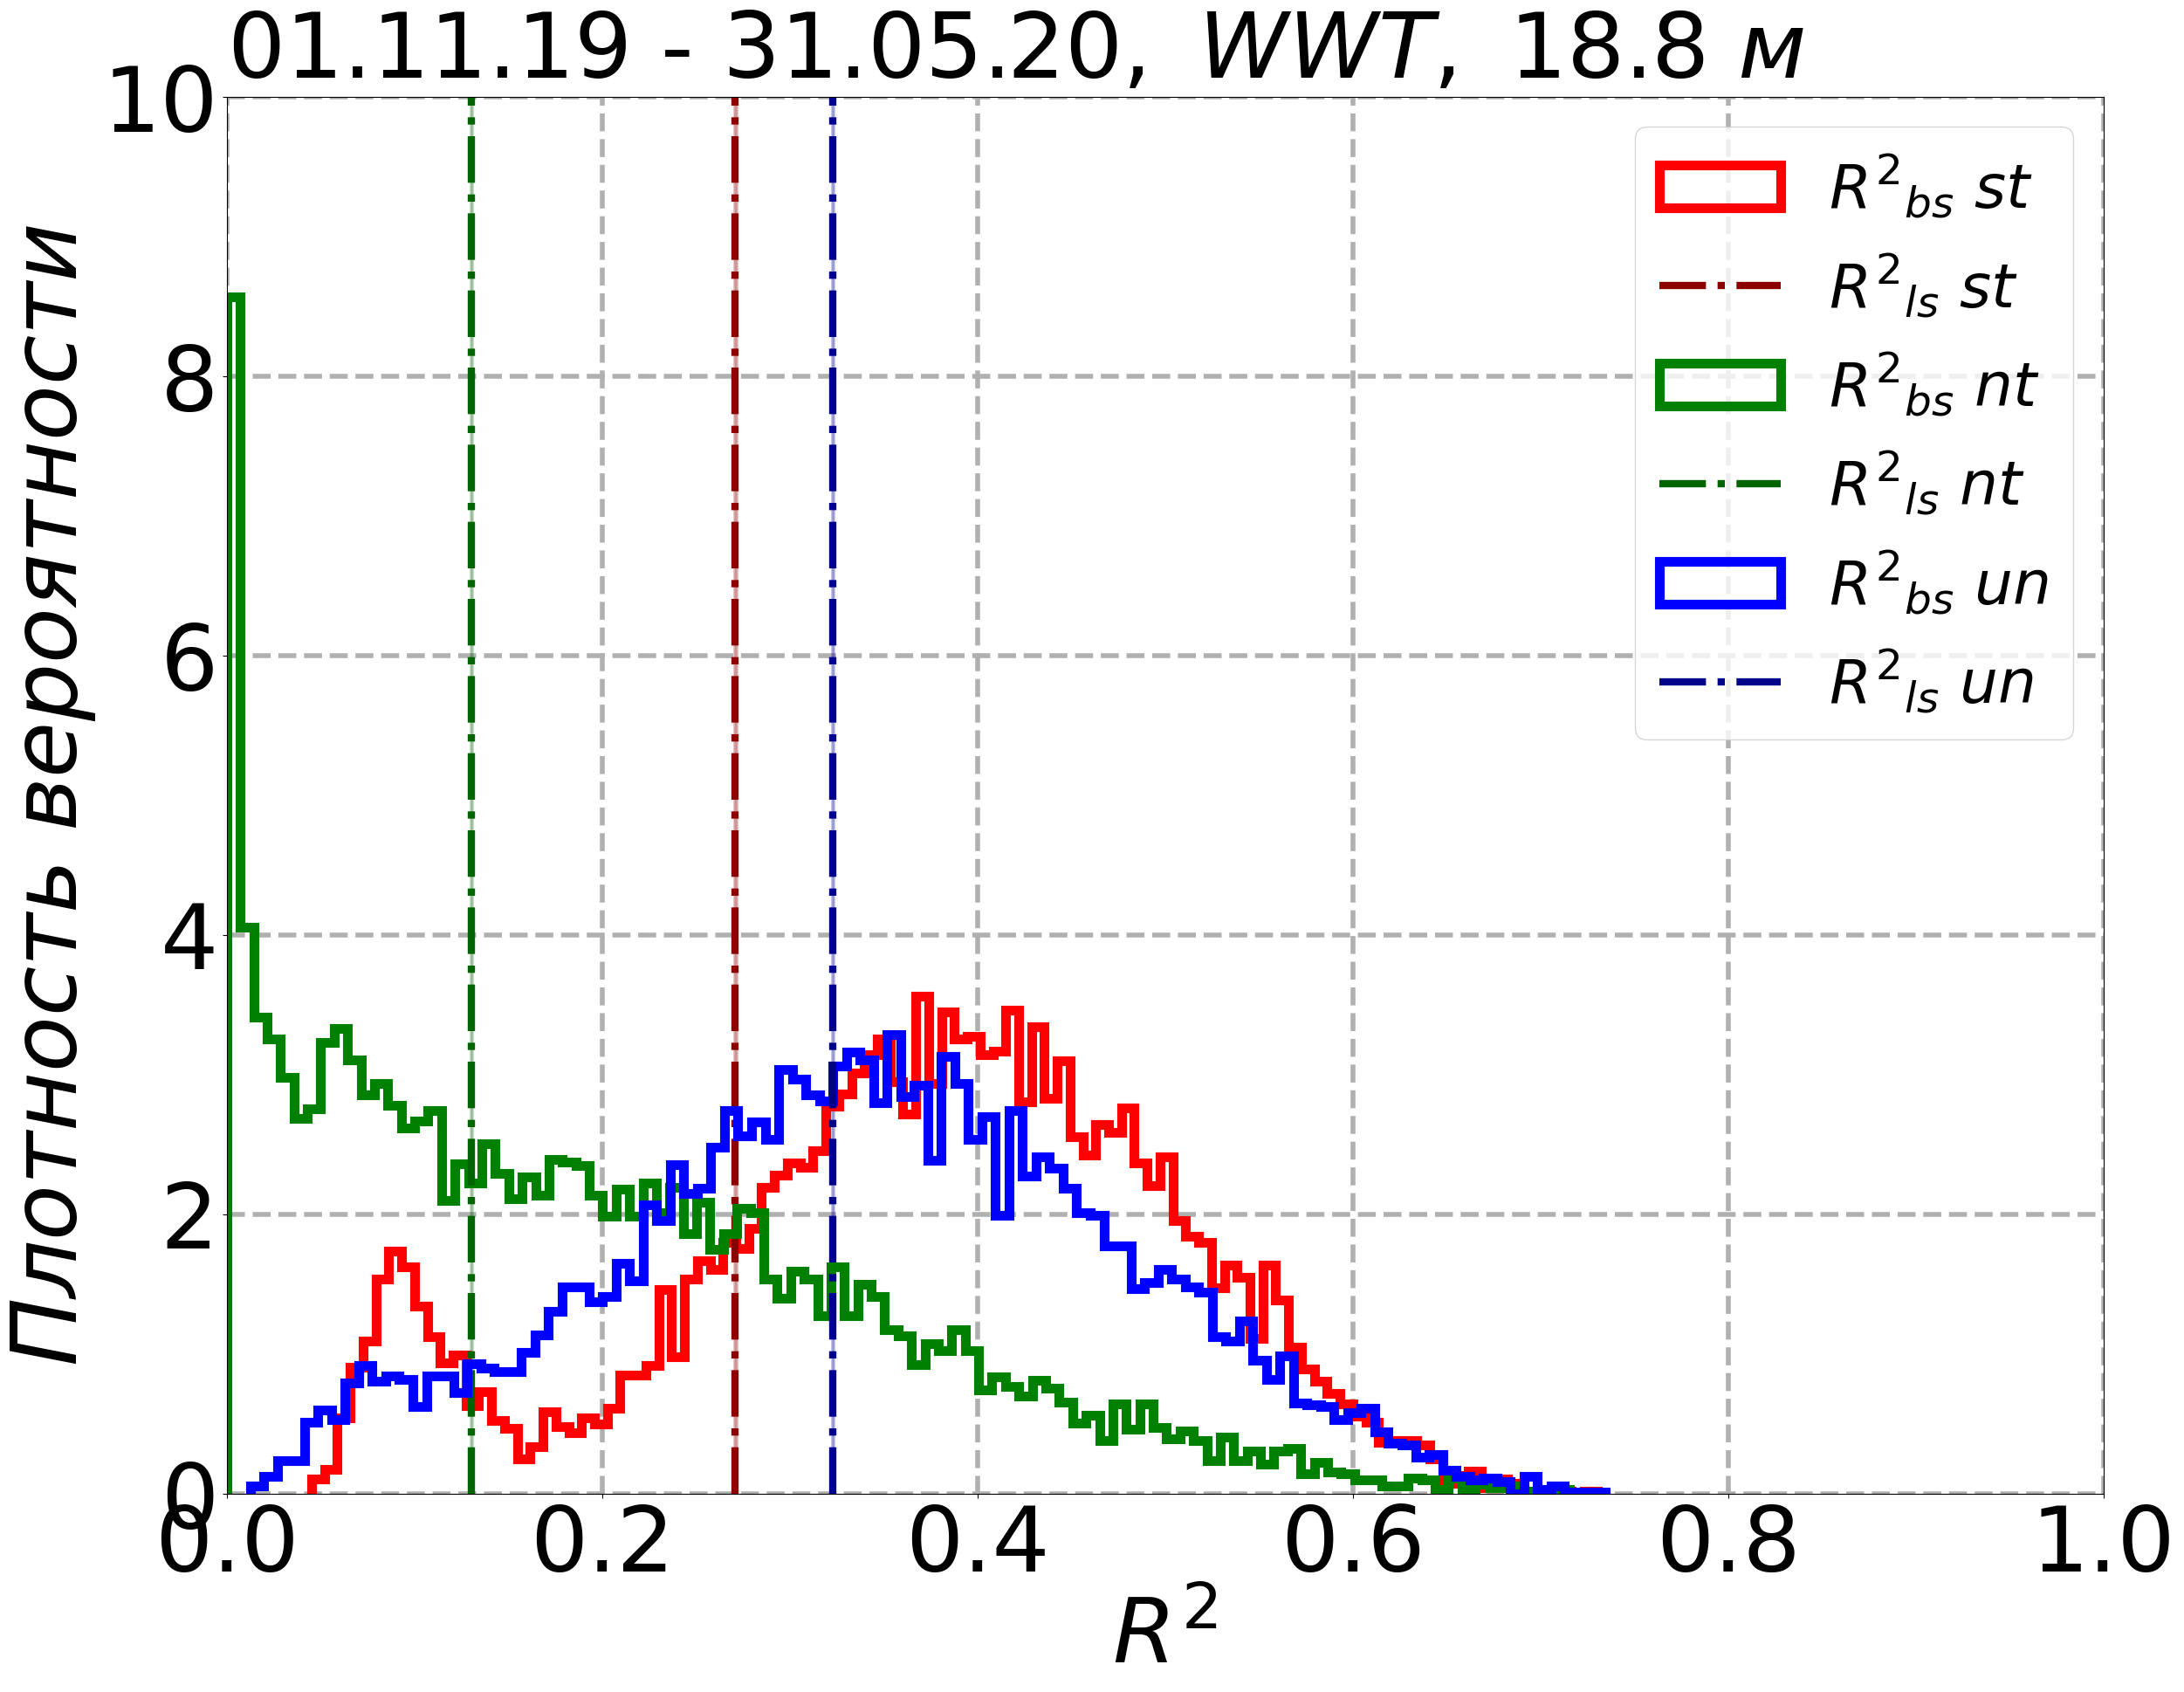

<Figure size 640x480 with 0 Axes>

In [289]:
out_dir = '/Users/ilyadrozd/Desktop/TOWER_DATA/Processed/bootstrap/'

fig2, ax2 = plt.subplots(figsize=(25, 20))
    
ax2 = bootstrap_hist(ax2, C_st, '$C$', gC_st, gci_C_st, '$st$', 'red')
ax2 = bootstrap_hist(ax2, C_nt, '$C$', gC_nt, gci_C_nt, '$nt$', 'green')
ax2 = bootstrap_hist(ax2, C_un, '$C$', gC_un, gci_C_un, '$un$', 'blue')
      
ax2.legend(loc='upper right', fontsize=50)
ax2.grid(linewidth=4, linestyle='--')
ax2.tick_params(axis='both', labelsize=75)
ax2.set_axisbelow(True)  
ax2.set_title(f'$01.11.19$ - $31.05.20,$ ${y},$ ${h}$ $м$', fontsize=75, loc='left')
ax2.set_xlabel(f'$C_{y[1]}$',fontsize=75)
ax2.set_ylabel('$Плотность$ $вероятности$',fontsize=75)
#ax2.set_xlim([min(x), max(x)])
ax2.set_ylim([0, 10])
plt.subplots_adjust(left=0.12, bottom=0.13, right=0.98, top=0.93)
plt.savefig(out_dir+f'{h}_{y}_C.jpg')
plt.show()
plt.clf()

fig2, ax2 = plt.subplots(figsize=(25, 20))
    
ax2 = bootstrap_hist(ax2, R2_st, '$R^2$', gR2_st, gci_R2_st, '$st$', 'red')
ax2 = bootstrap_hist(ax2, R2_nt, '$R^2$', gR2_nt, gci_R2_nt, '$nt$', 'green')
ax2 = bootstrap_hist(ax2, R2_un, '$R^2$', gR2_un, gci_R2_un, '$un$', 'blue')
      
ax2.legend(fontsize=50)
ax2.grid(linewidth=4, linestyle='--')
ax2.tick_params(axis='both', labelsize=75)
ax2.set_axisbelow(True)  
ax2.set_title(f'$01.11.19$ - $31.05.20,$ ${y},$ ${h}$ $м$', fontsize=75, loc='left')
ax2.set_xlabel('$R^2$',fontsize=75)
ax2.set_ylabel('$Плотность$ $вероятности$',fontsize=75)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 10])
plt.subplots_adjust(left=0.12, bottom=0.13, right=0.97, top=0.93)
fig2.savefig(out_dir+f'{h}_{y}_R2.jpg')
plt.show()
plt.clf()

In [298]:
def qqplot(L, h, moment, str_name):
    fig, ax = plt.subplots()
    sm.qqplot(L[moment], stats.norm, fit=True, line='s', ax=ax)
    ax.grid(linestyle='--')
    ax.tick_params(axis='both')
    ax.set_title(f'01.11.19 - 31.05.20, {h}', fontsize=15)
    ax.set_axisbelow(True)  
    ax.set_xlabel('Квантили нормального распределения', fontsize=15)
    ax.set_ylabel(f'Квантили {moment}', fontsize=15)
    #ax2.legend(loc='upper left', fontsize=50)
    #ax2.grid(linewidth=4, linestyle='--')
    ax.tick_params(axis='both', labelsize=15)
    plt.subplots_adjust(left=0.2, bottom=0.13, right=0.96, top=0.88)
    #fig2.savefig(out_dir+file_name)

/Users/ilyadrozd/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.49550092220306396, pvalue=0.0)
ShapiroResult(statistic=0.49612903594970703, pvalue=0.0)
ShapiroResult(statistic=0.3613424301147461, pvalue=0.0)
ShapiroResult(statistic=0.27181196212768555, pvalue=0.0)
ShapiroResult(statistic=0.7493717670440674, pvalue=0.0)
ShapiroResult(statistic=0.6116289496421814, pvalue=0.0)
ShapiroResult(statistic=0.7146337032318115, pvalue=0.0)
ShapiroResult(statistic=0.6737526655197144, pvalue=0.0)


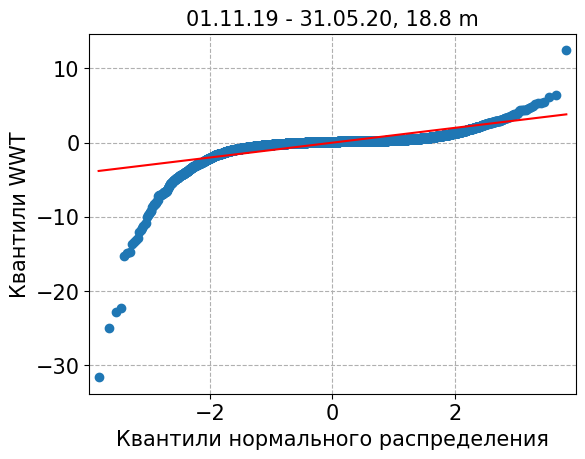

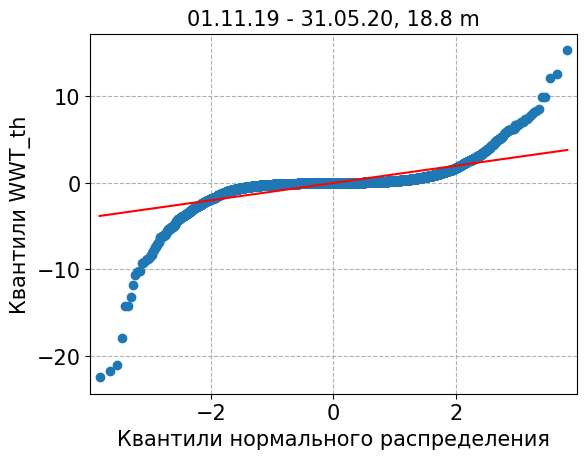

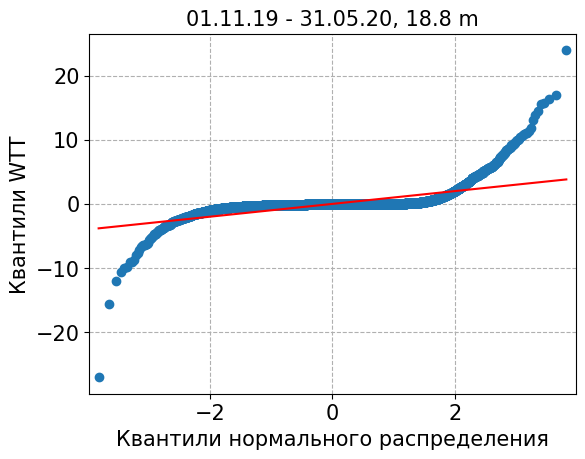

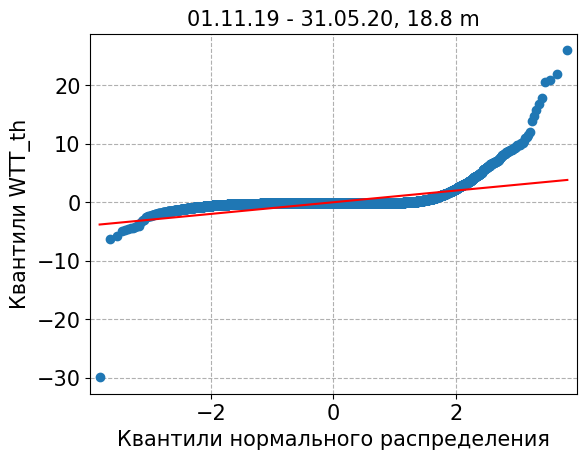

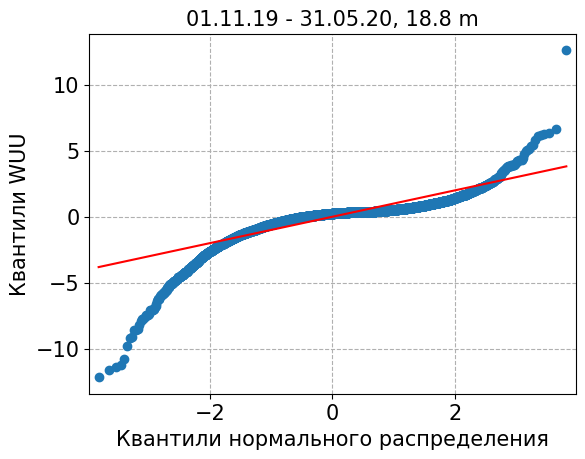

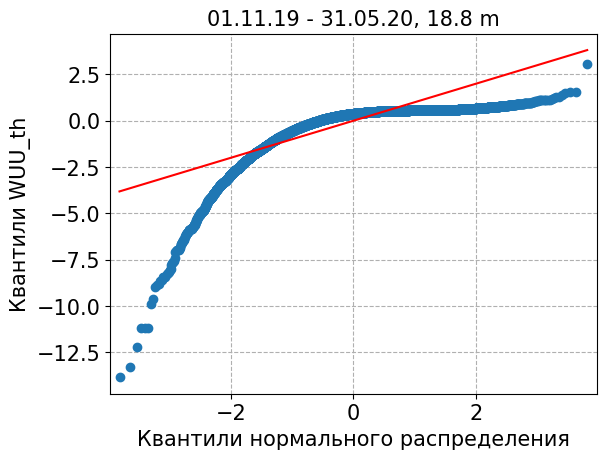

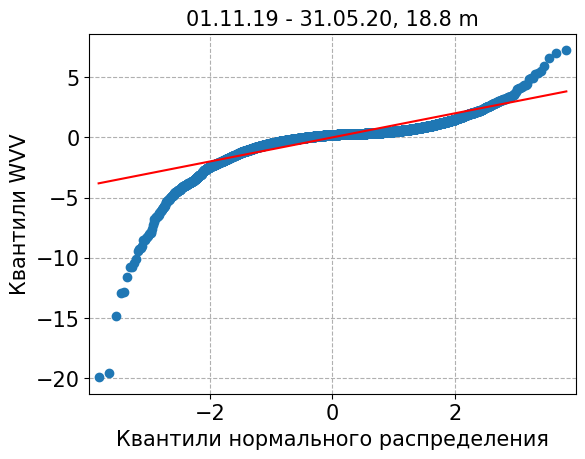

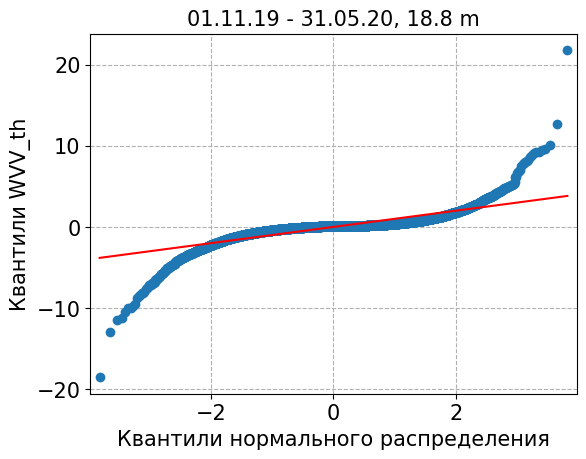

In [363]:
L=L3.dropna()
strat='z/L'
nt_str=0.05

L_st = L.loc[L[strat]>nt_str]
L_nt = L.loc[(L[strat]<nt_str)&(L[strat]>-nt_str)]
L_un = L.loc[L[strat]<-nt_str]

for moment in ['WWT', 'WWT_th', 'WTT', 'WTT_th', 'WUU', 'WUU_th', 'WVV', 'WVV_th']:
    qqplot(L, h='18.8 m', moment=moment, str_name = '')
    print(shapiro(L[moment]))


In [362]:
from scipy.stats import shapiro